# Numerical resolution of KdV equation using a Finite Volume method

## Model : Korteweg - de Vries (KdV) equation :

We will compute an approximate solution to the KdV equation, which models a wave propagation accpounting for nonlinear ansd dispersive effects : 

\begin{equation}
\begin{cases}
    u_t + au_x + b(u^2)_x + u_{xxx} = 0 \ , \ \ x \in [x_{min},x_{max}], \ \ t \in [0, t_{max}] \\
    u(x,0) = \Phi(x)
\end{cases}
\end{equation}

The constant coefficients $a$ and $b$ were introduced in order to analyze the influence of the phenomena acting in the model (pure advrection, nonlinearity and diffusion).

The kdV equation will be split in two equations, leading to the resolution of the following problem in each time step: 

\begin{equation}
\begin{cases}
    v_t + av_x + b(v^2)_x = 0 \ \ ,\ t \in [t_n,t_{n+1}], \  v(t_n) = u(t_n) \\
    w_t + w_{xxx} = 0 \ \ , \ t \in [t_n,t_{n+1}], \  w(t_n) = v(t_{n+1}) \\
    u(t_{n+1}) = v(t_{n+1})
\end{cases}
\end{equation}

## First equation
$ v_t + f(v)_x = 0, \ \ f(v) = av + bv^2 $


### Temporal discretization

#### Euler
$v_i^{n+1} = v_i^n - \Delta t  \  f(v_i^n)_x$

#### 4th order Runge-Kutta
\begin{equation}
\begin{cases}
k_1 = - f(v_i^n)_x \\
k_2 = - f\left(v_i^n + k_1\frac{\Delta t }{2}\right)_x \\
k_3 = - f\left(v_i^n + k_2\frac{\Delta t }{2}\right)_x \\
k_4 = - f(v_i^n + k_3 \Delta t)_x \\
v_i^{n+1} = v_i^n + \frac{\Delta t}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{cases}
\end{equation}



### Spatial discretization
$ f(v_i^n)_x = \frac{f\left(v_{i+1/2}^n\right) - f\left(v_{i-1/2}^n\right)}{\Delta x}$


### Choice of the steps
In the non-conservative form, the equation is written as

$v_t +  (1+2v)v_x = 0$

which configures an advection problem with velocity $1+2v$

The space and time steps must verify the CFL condition : 

$(a+2bv)\frac{\Delta t}{\Delta x} \leq 1$

in order to avoid non-physical behaviours (e.g. mass increasing). Thereforem for each time step, we will chose, for small $\epsilon$

$\Delta t = \frac{\Delta x}{a+2b\max\limits_{x}|v|} - \epsilon$





### Evaluation of the solution on cell interfaces : resolution of the Riemann problem
In each interface between two cells of the discrete domain, the follozing Riemann problem will be solved :

\begin{equation}
\begin{cases}
v_t + f(v)_x = 0 \\
v(x,0) = v^- \ , \ x < 0 \\
v(x,0) = v^+ \ , \ x > 0
\end{cases}
\end{equation}

where the boundary is located at $x=0$ and $v^-$ and $v^+$ are the solutions in its two neighbour cells.

The flux function $f$ is uniformly convex, so the Riemann problem has a unique weak, admissible solution (REFERENCE) :

* If $v^- > v^+$  (shock) : 
\begin{equation}
v(x,t) = 
\begin{cases}
v^- \ ,\ \   f(v^-) > f(v^+) \\
v^+ \ ,\ \ f(v^-) < f(v^+)
\end{cases}
\end{equation}

* If $v^+ > v^-$  (rarefaction wave) :
\begin{equation}
v(x,t) = 
\begin{cases}
v^- \ ,\ \ f'(v^-) > 0 \\
\left(f'\right)^{-1}(v) \ ,\ \ f'(v^-) < 0 < f'(v^+) \\
v^+ \ ,\ \ f'(v^+) < 0 
\end{cases}
\end{equation}

## Second equation

The second equation will be solved using the Fourier method. Let $\hat{w}(k,t_n)$ be the Fourier coefficients of $w(x,t_n)$.  The Fourier transform of the equation

$w_t+w_{xxx}=0$

gives

$(\hat{w})_t(k,t) - ik^3\hat{w}(k,t)$ = 0

It is an ODE in $t$ which solution is
$\hat{w}(k,t) = e^{ik^3(t-t_n)}\hat{w}(k,t_n)$

The inverse Fourier transform using the coefficients $\hat{w}(k,t_{n+1})$ gives $w(x,t_{n+1})$

## Model functions

In [1]:
%%writefile kdv.py

import numpy as np
def Flux(u,a,b):
    return a*u + b*u*u
def Fluxder(u,a,b):
    return a + 2.0*b*u
def Fluxderinv(u,a,b):
    return (u-1.*a)/(2.*b)

Overwriting kdv.py


In [2]:
%%writefile kdv.py -a

def Riemann(u,x,t,a,b):
    uint = np.zeros_like(x)
    for  i in range(0,x.size-1):
        #incl = x[i]/t
        incl = 0
        um = u[i]
        up = u[i+1]
        if um == up :
            uint[i] = um
        elif  um > up:
            sigma = (Flux(um,a,b) - Flux(up,a,b))/(um-up)
            if incl < sigma:
                uint[i] = um
            else:
                uint[i] = up
        else:
            if incl < Fluxder(um,a,b) :
                uint[i] = um
            elif incl > Fluxder(up,a,b) :
                uint[i] = up
            else:
                uint[i] = Fluxderinv(incl,a,b)
    #uint[0] = u[0]
    uint[x.size-1] = u[x.size-1]
    return uint

Appending to kdv.py


In [3]:
%%writefile kdv.py -a

def Euler(u,dx,dt,periodic):
    umm = np.roll(u,1)
    if periodic :
        umm[0] = u[u.size-1]
    
    f = Flux(u)
    fmm = Flux(umm)
    
    u2 = u - dt/dx*(f-fmm)
    
    return u2

Appending to kdv.py


In [4]:
%%writefile kdv.py -a

def getRKCoef(u,x,t,dx,dt,a,b,periodic):
    uint = Riemann(u,x,t,a,b)
    uintmm = np.roll(uint,1)
    if periodic :
        uintmm[0] = uintmm[u.size-1]
    f = Flux(uint,a,b)
    fmm = Flux(uintmm,a,b)
    return dt*(fmm-f)/dx
        
def RK4(u,x,t,dx,dt,a,b,periodic):
        
    k1 = getRKCoef(u,x,t,dx,dt,a,b,periodic)
    k2 = getRKCoef(u+k1/2,x,t,dx,dt,a,b,periodic)
    k3 = getRKCoef(u+k2/2,x,t,dx,dt,a,b,periodic)
    k4 = getRKCoef(u+k3,x,t,dx,dt,a,b,periodic)
    
    u2 = u + 1./6.*(k1+2*k2+2*k3+k4)
    
    return u2

Appending to kdv.py


In [5]:
%%writefile kdv.py -a

def FourierSolver(u,t,dt,dx):
    freq = np.linspace(0,u.size-1,u.size)
    uhat = np.fft.fft(u)
    uhat = uhat*np.exp(dt*1.j*np.power(np.fft.fftfreq(uhat.size,d=dx),3))
    u2 = np.fft.ifft(uhat)
#    if not (np.all(np.isreal(u2))):
#        print(u2)
#        sys.exit("Error in Fourier method")
    return np.real(u2)

Appending to kdv.py


In [6]:
%%writefile kdv.py -a

def runRk4FVFourier(x,u,t0,tmax,a,b):
    t = t0
    tall = np.ones(1)*t0
    u0 = u
    uall = u
    u0min = np.amin(u)
    u0max = np.amax(u)
    dx = np.diff(x)[0]
    iter = 0
    eps = 1e-6

    ##### Parameters
    printstep = 5
    periodic = 1
    #a = 1
    #b = 1


    while t<tmax:
        iter = iter + 1
        umax = np.amax(np.absolute(u))
        dt = dx/(1.*a+2*b*umax) - eps     # CFL CONDITION (???)
#         print dt
#         dt = 0.0020
        #dt = dx
        t = t+dt
        u = RK4(u,x,t,dx,dt,a,b,periodic)
        u = FourierSolver(u,t,dt,dx)

        if not periodic:
            u[0] = uleft ## Boundary conditions ?
            u[nx] = uright
        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
    return uall,tall


Appending to kdv.py


In [7]:
%%writefile kdv.py -a

def discretizeSpace(xmin,xmax,dx) :
    nx = int((xmax-xmin)/dx)
    x = np.linspace(xmin, xmax,nx+1)    
    return x

Appending to kdv.py


In [8]:
#######

### def setProblem(xmin,xmax,dx,f,args)
### x = kdv.discretizeSpace(xmin,xmax,dx)
### u = f(args)
### return x,f

## Scale study

According to the paper of BBM (1971), nonlinearity is characterized by a parameter $\epsilon$ such that if characteristics are written in the form

$$ \frac{1}{c_0} \frac{dx}{dt} = 1+ bu$$

### Comparison of non-linearity

Given the equations in the form $u_t+ u_x + (u^2)_x + u_{xxx} = 0$, replacing $u=AU$, with $A$ meaning the amplitude of the wave, then we obtain $$U_t + U_x + A (U^2)_x + U_{xxx}=0$$, wich means that for small $A$ the non linear term vanishes while for big $A$ the non-linear term dominates.

The idea is to see how different values of $A$ will affect the propagation of the wave and its shape

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import kdv

%matplotlib inline

In [10]:
L = 2
xmin = -L
xmax = L
dx = 0.025
x = kdv.discretizeSpace(xmin,xmax,dx)

#### First wave: Strong  non-linearity ( $A=10.0$)

In [11]:
u = np.zeros_like(x)
u = np.where( (x>=0.3)*(x<=0.4), 10.0, u)
# A = 10.0
# u = np.exp(-(x-xmax/2.0)**2/.01)  
u1, t1 = kdv.runRk4FVFourier(x,u,t0=0,tmax=0.5,a=1,b=1)

#### Second wave: Moderate non linearity ($A = 1.0$)

In [12]:
x.min(),x.max()

(-2.0, 2.0)

In [13]:
u = np.zeros_like(x)
u = np.where( (x>=0.3)*(x<=0.4), 1.0, u)
u2, t2 = kdv.runRk4FVFourier(x,u,t0=0,tmax=0.5,a=1,b=1)

#### Third wave: Weak non linearity ($A= 0.0001$)

In [14]:
u = np.zeros_like(x)
u = np.where( (x>=0.3)*(x<=0.4), 0.0001, u)
u3, t3 = kdv.runRk4FVFourier(x,u,t0=0,tmax=0.5,a=1,b=1)

Notice that the $CFL$ condition is sensitive to the initial amplitude

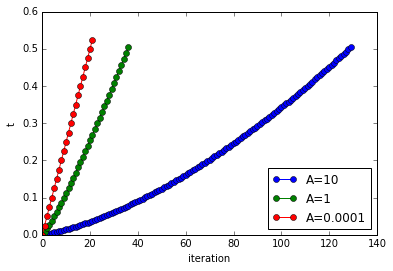

In [15]:
plt.plot(t1,'o-',label='A=10')
plt.plot(t2,'o-',label='A=1')
plt.plot(t3,'o-',label='A=0.0001')
plt.xlabel('iteration')
plt.ylabel('t')
plt.legend(loc=0)

C:\Users\PTI\Miniconda2\lib\site-packages\matplotlib\legend.py:337: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '



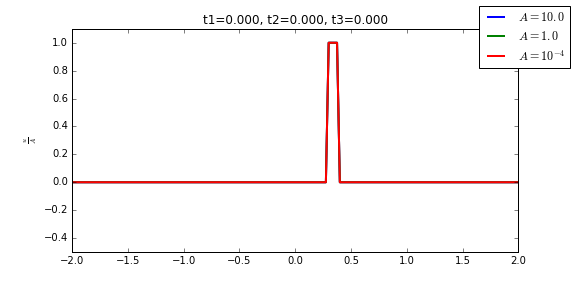
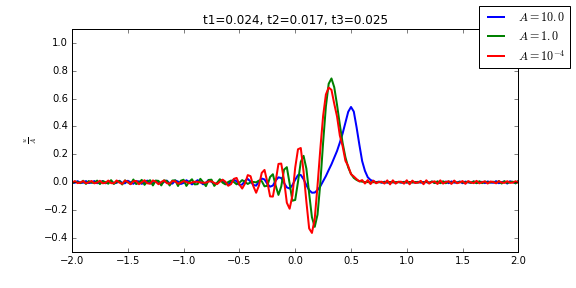
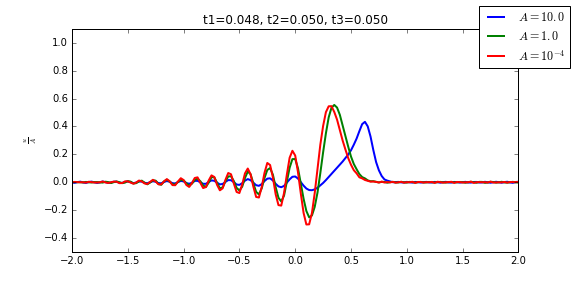
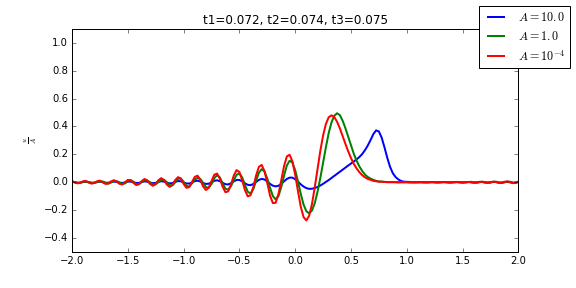
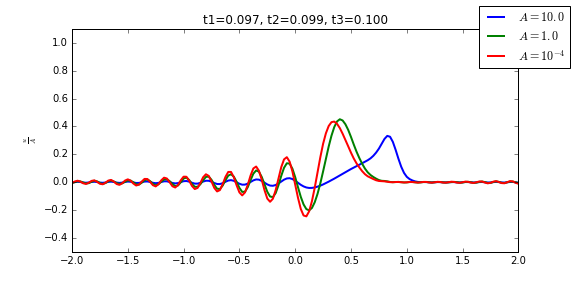
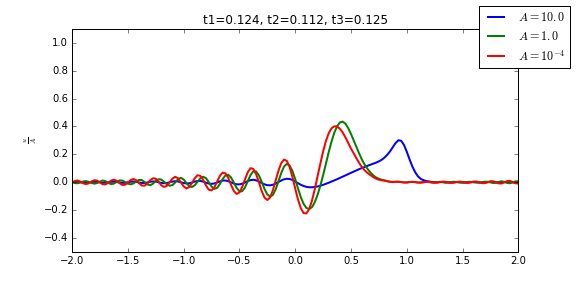
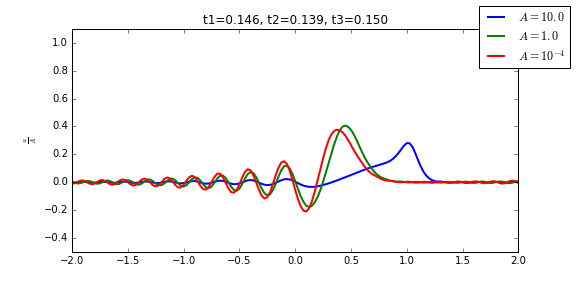
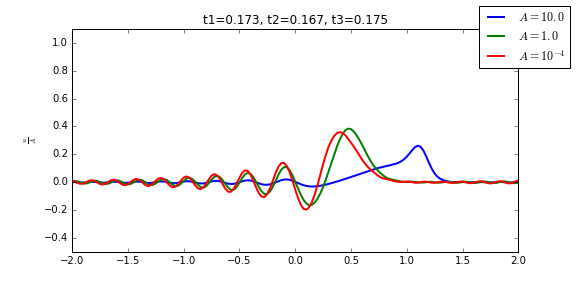
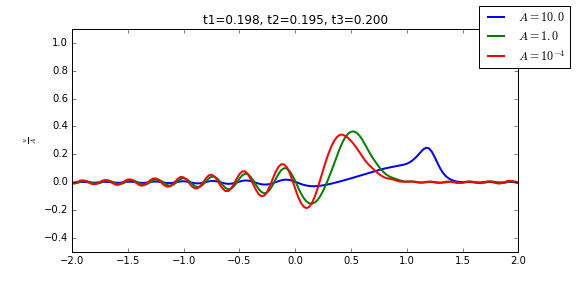
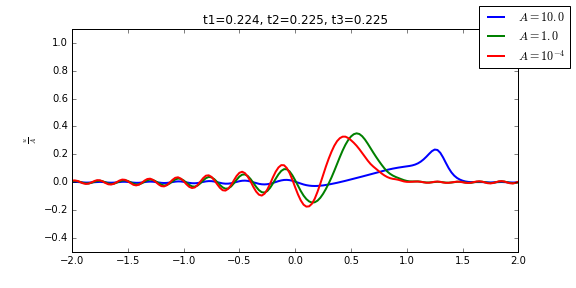
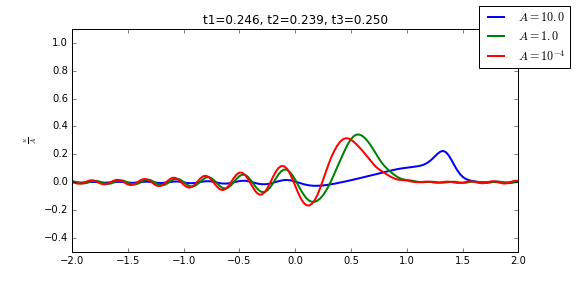
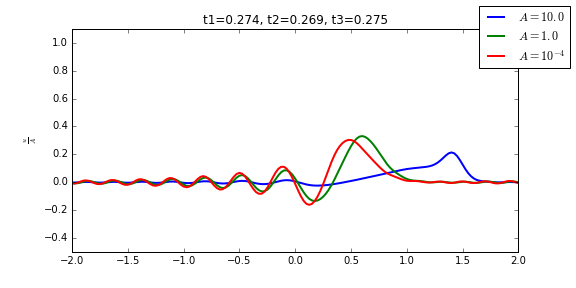
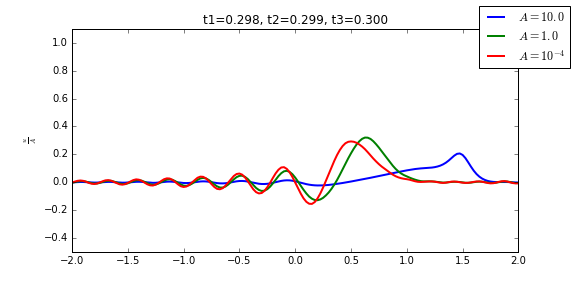
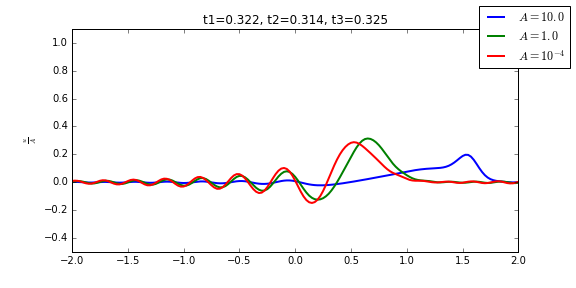
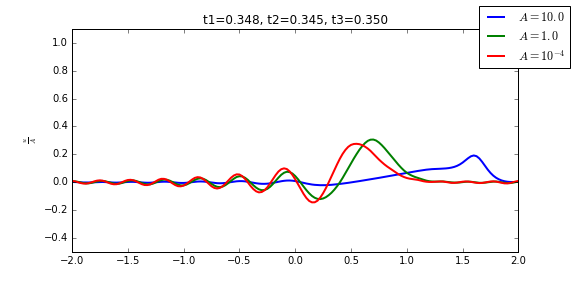
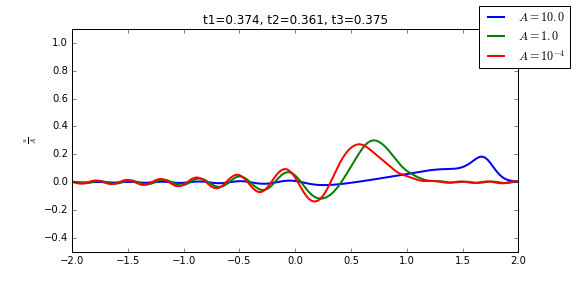
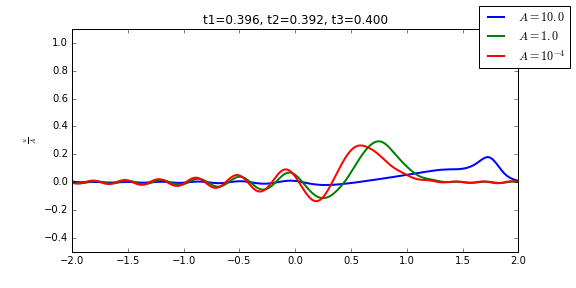
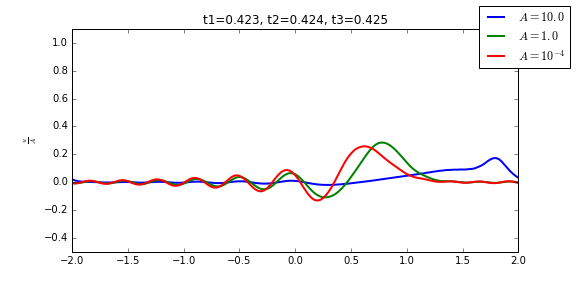
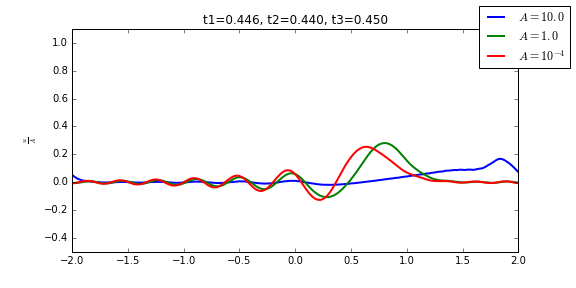
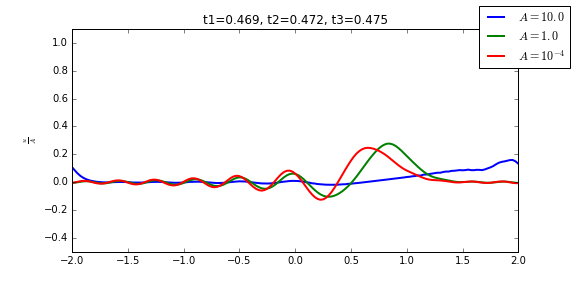
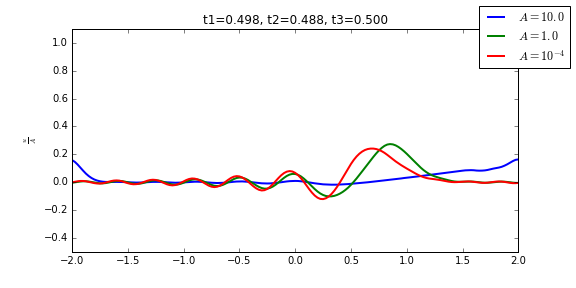

In [16]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure(figsize=(8,4))
ax = plt.axes(xlim=(xmin, xmax), ylim=(-0.5, 1.1))
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
ax.set_ylabel(r'$\frac{u}{A}$')
title = ax.set_title(r'$t=0.0 s$')
fig.legend((line1, line2, line3),(r'$A=10.0$',r'$A=1.0$', r'$A=10^{-4}$'),loc=0)
# def init():
#     line1.set_data([], [])
#     line2.set_data([], [])
#     return line1,line2

def animate(i):
    i1 = np.where(t1<=t3[i])[0][-1]
    i2 = np.where(t2<=t3[i])[0][-1]
    line1.set_data(x, u1[:,i1]/10.0)
    line2.set_data(x, u2[:,i2]/1.0)
    line3.set_data(x, u3[:,i]/0.0001)
    title.set_text('t1=%.3f, t2=%.3f, t3=%.3f'%(t1[i1],t2[i2],t3[i]))
    #ax.annotate(r'$t = %f $' %tall[i],(1,1))
    return line1,line2

animation.FuncAnimation(fig, animate, frames=t3.shape[0]-1, interval=150)

#### Observations:
* Bigger amplitude meant more deformtion on the wave
* Bigger amplitude meant smaller amplitude in the end (more disipation)
* The wave train persists with the same frequency independent of the amplitude

## Comparison of dispersion

In [17]:
L = 10
xmin = -L
xmax = L
dx = 0.025
x = kdv.discretizeSpace(xmin,xmax,dx)

In [18]:
u = np.zeros_like(x)
u = np.where( (x>=-0.2)*(x<=0.2), 1.0, u)
# A = 10.0
# u = np.exp(-(x-xmax/2.0)**2/.01)  
u1, t1 = kdv.runRk4FVFourier(x,u,t0=0,tmax=0.5,a=1,b=1)

In [19]:
u = np.zeros_like(x)
u = np.where( (x>=-0.5)*(x<=0.5), 1.0, u)
# A = 10.0
# u = np.exp(-(x-xmax/2.0)**2/.01)  
u2, t2 = kdv.runRk4FVFourier(x,u,t0=0,tmax=0.5,a=1,b=1)

In [20]:
u = np.zeros_like(x)
u = np.where( (x>=-0.75)*(x<=0.75), 1.0, u)
# A = 10.0
# u = np.exp(-(x-xmax/2.0)**2/.01)  
u3, t3 = kdv.runRk4FVFourier(x,u,t0=0,tmax=0.5,a=1,b=1)


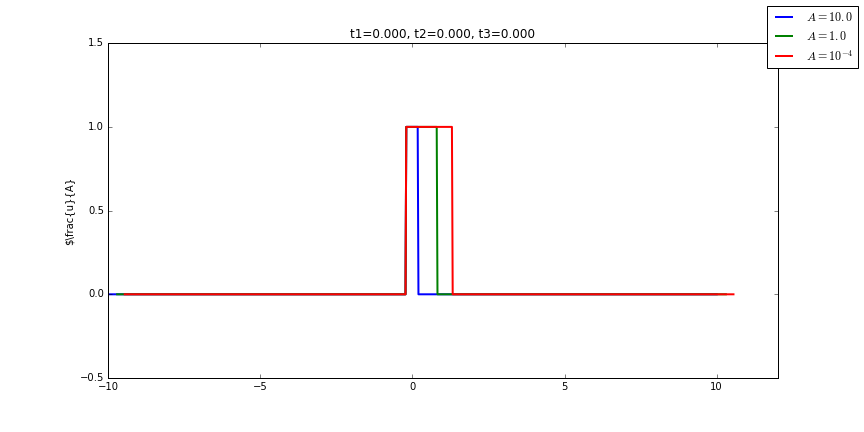
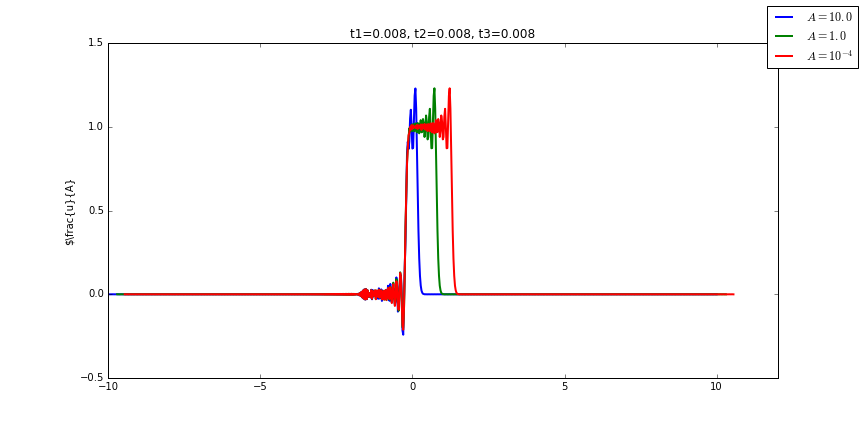
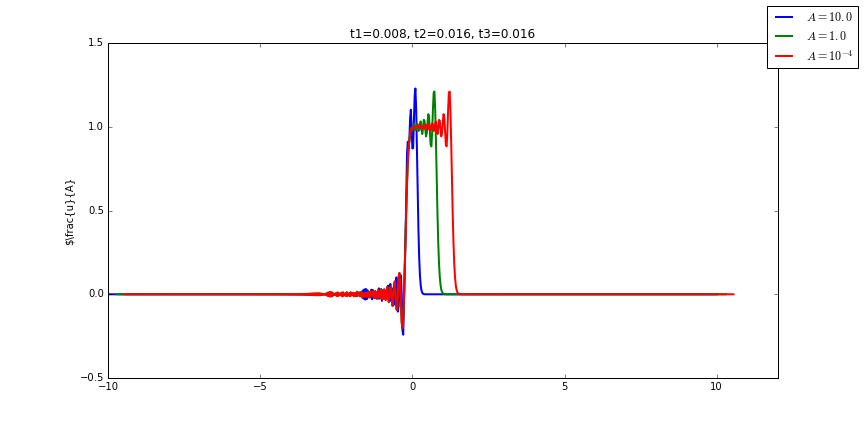
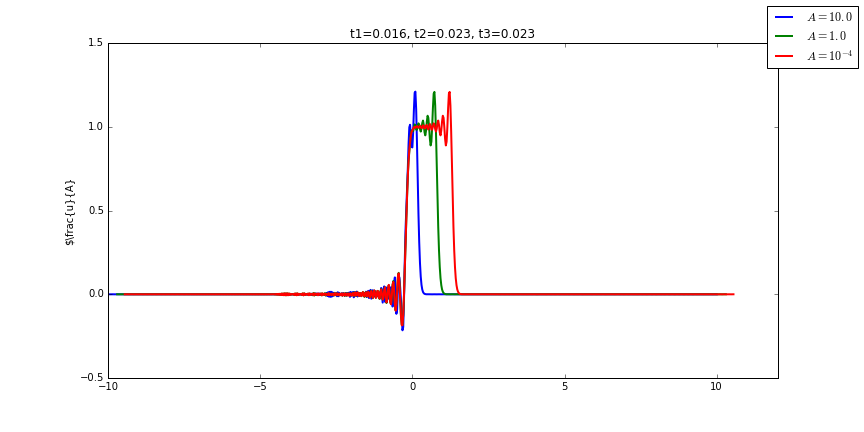
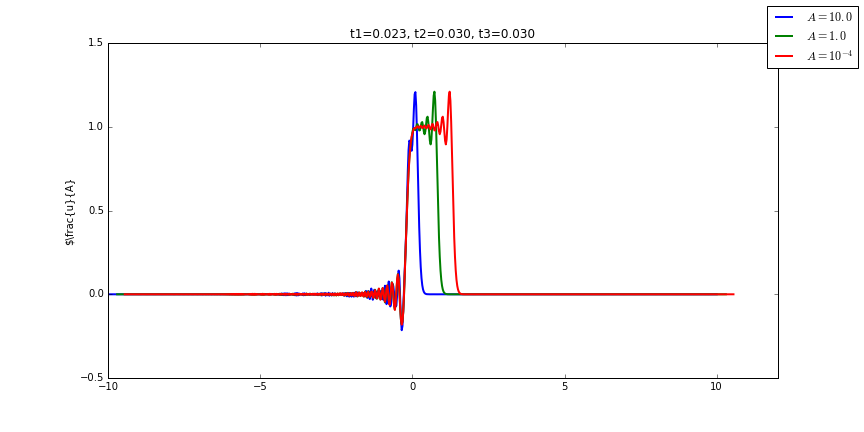
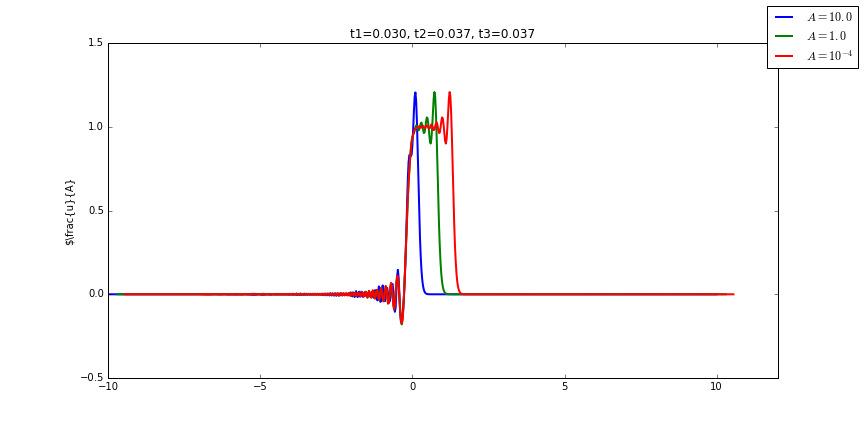
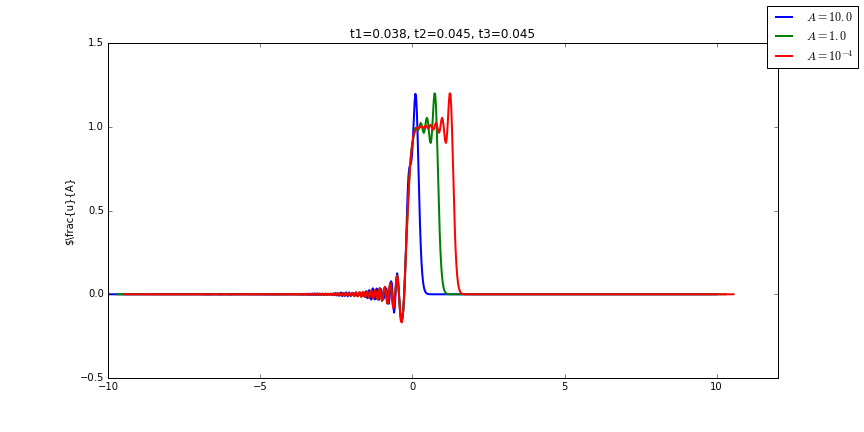
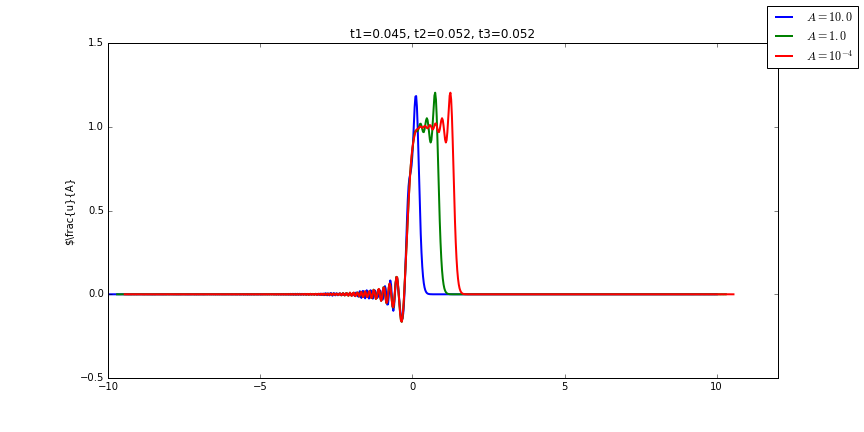
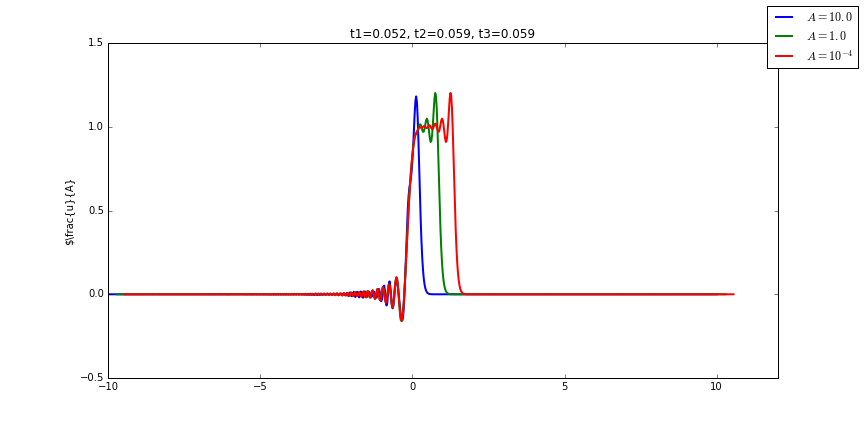
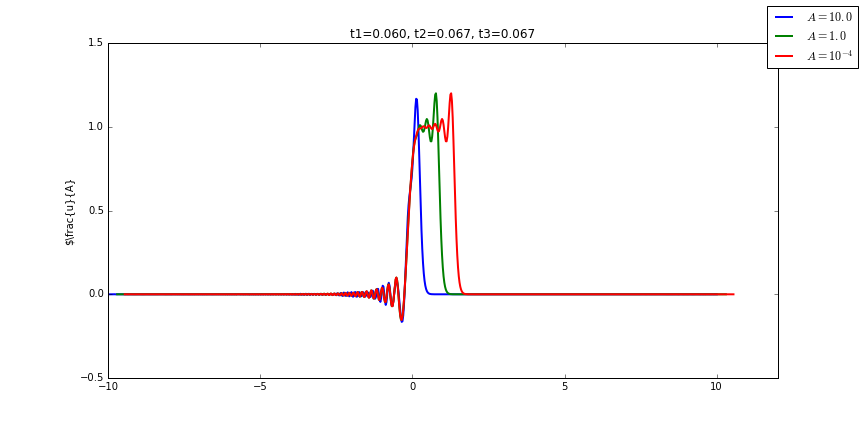
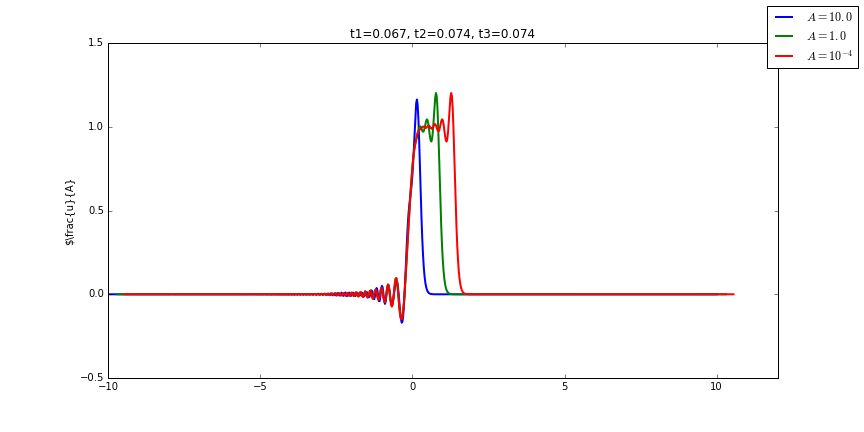
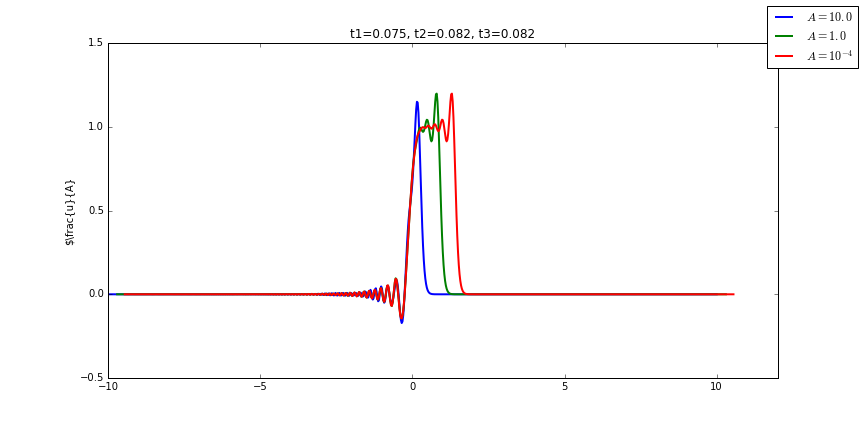
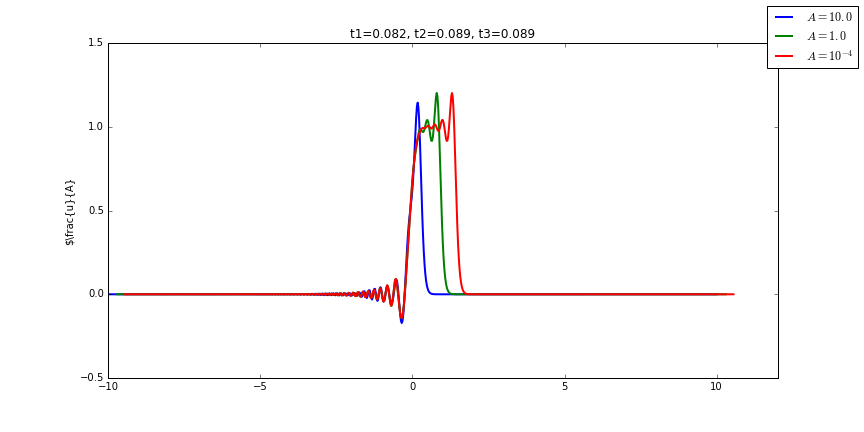
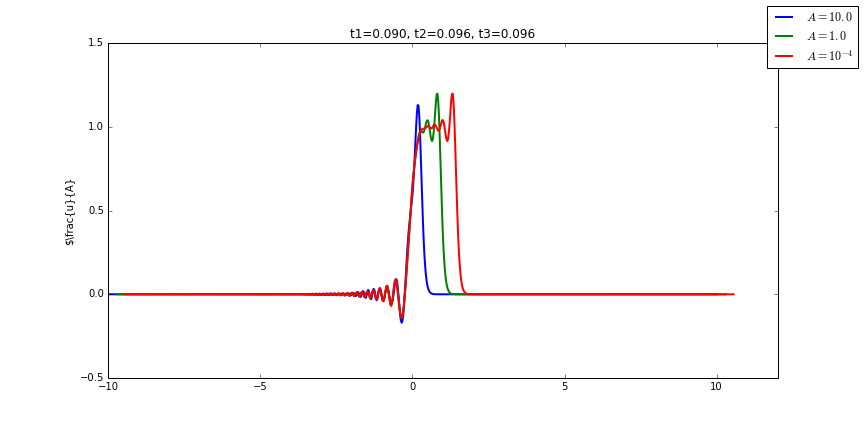
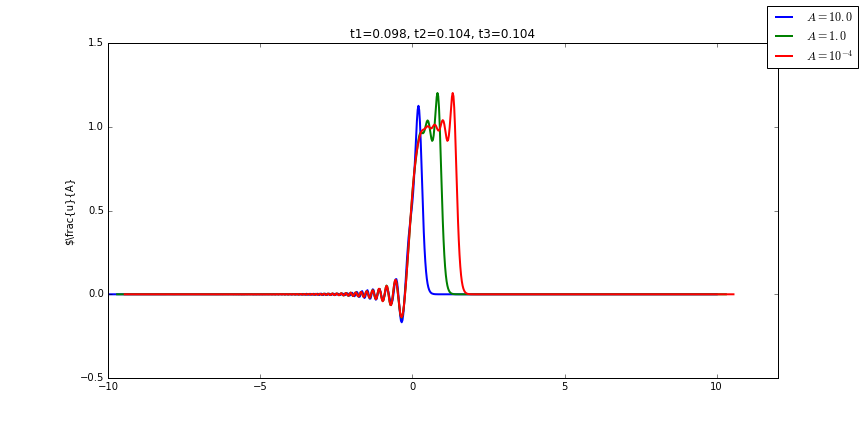
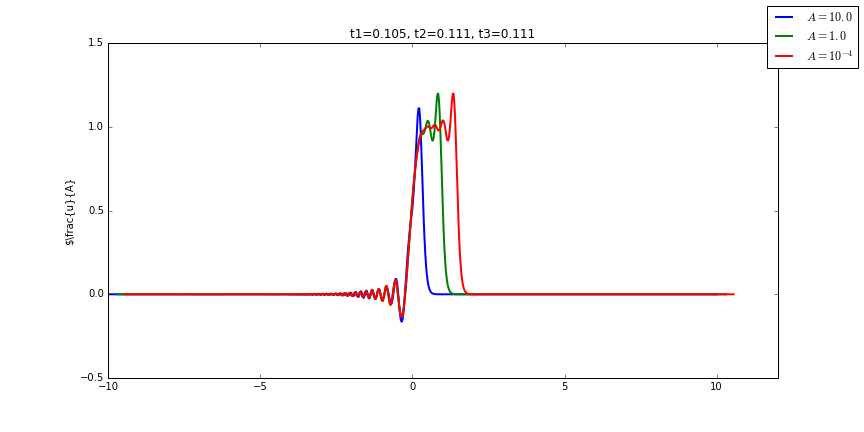
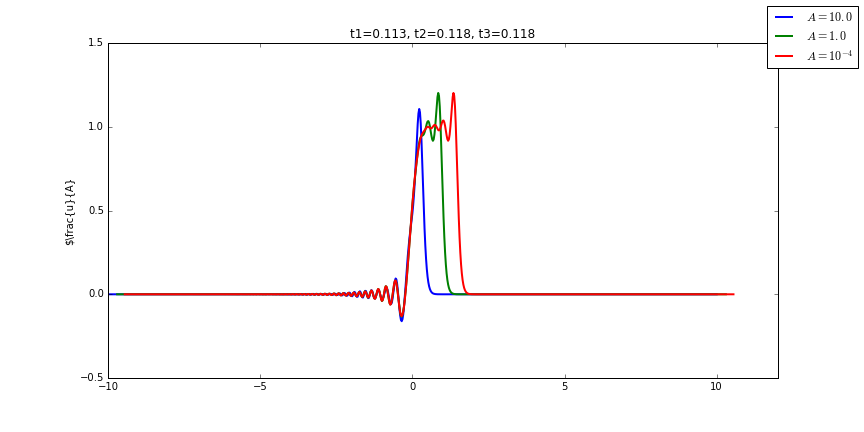
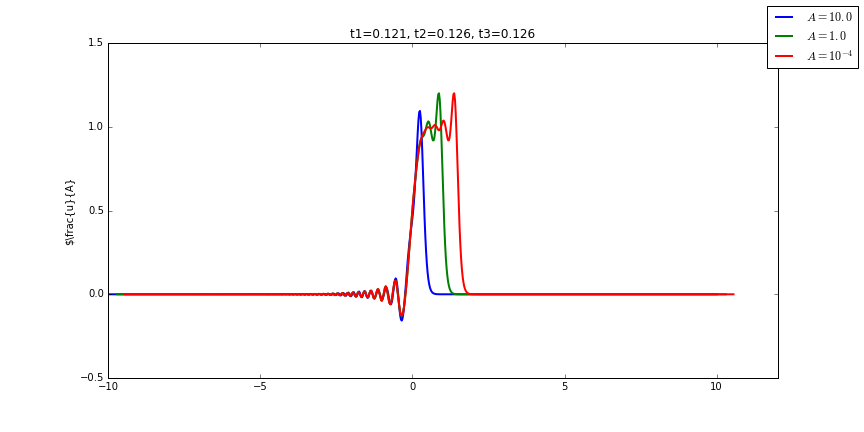
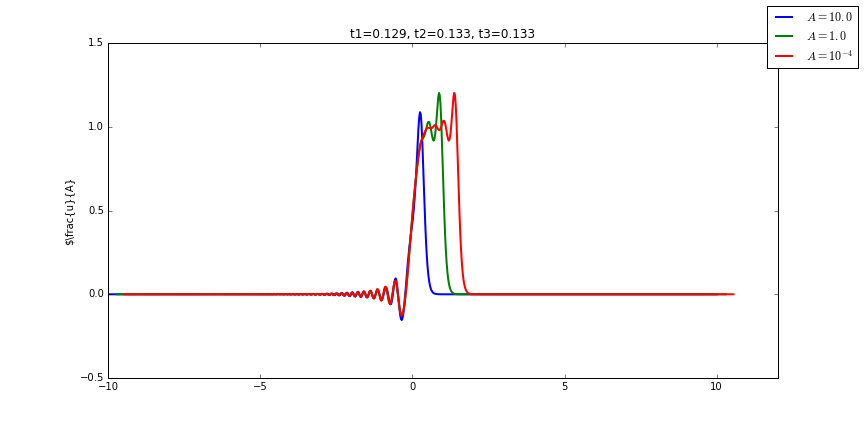
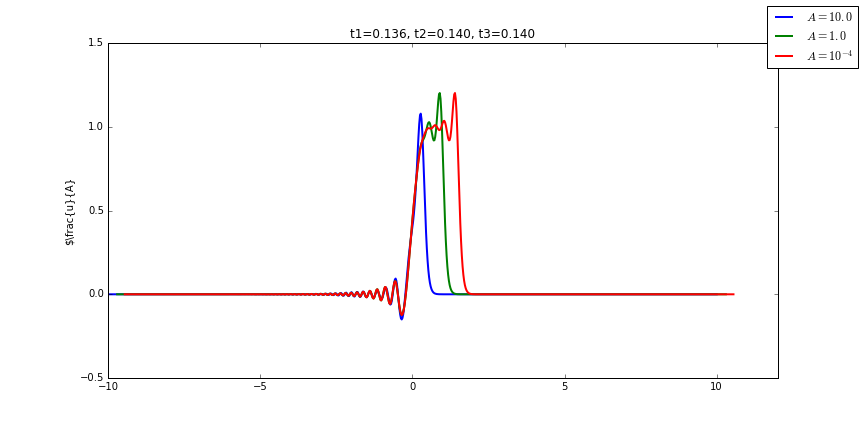
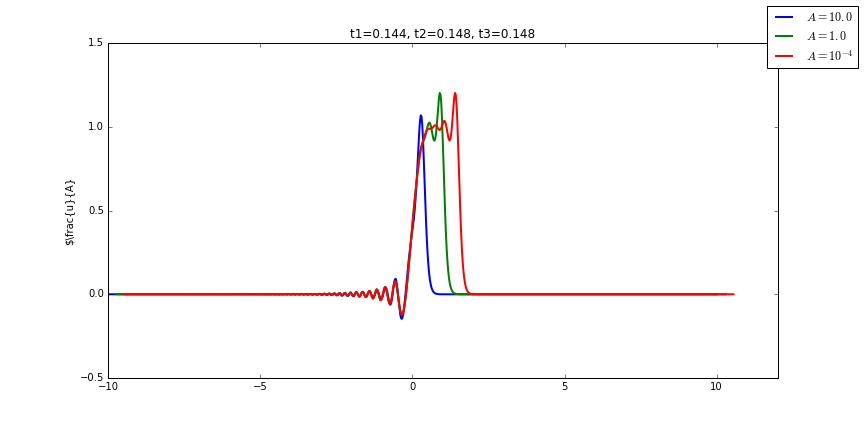
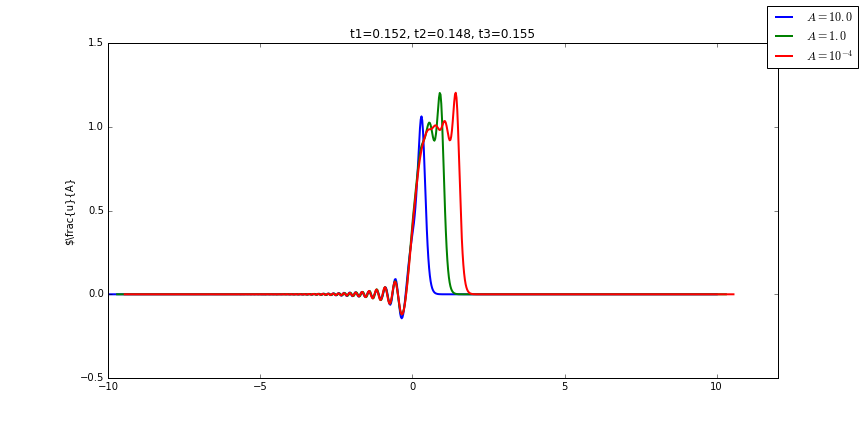
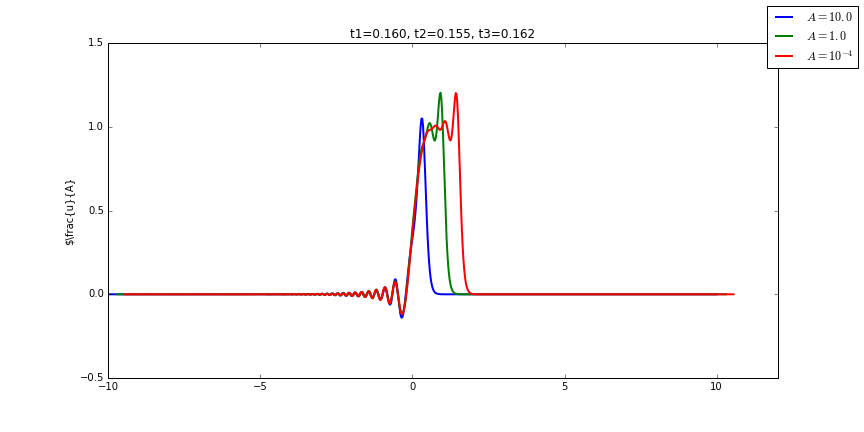
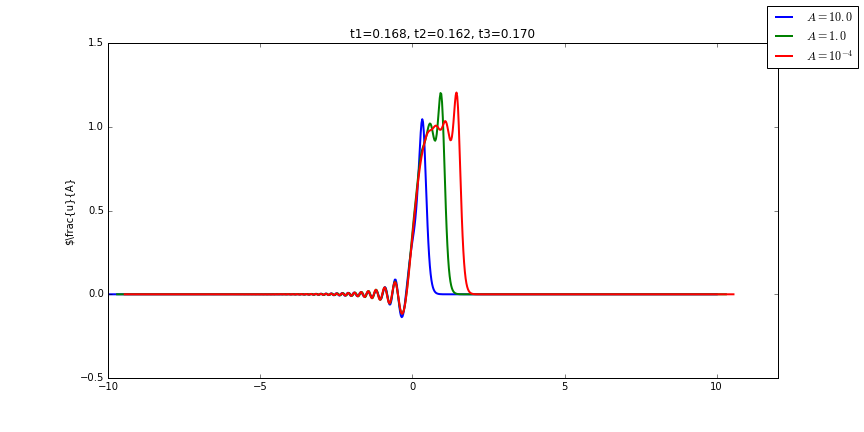
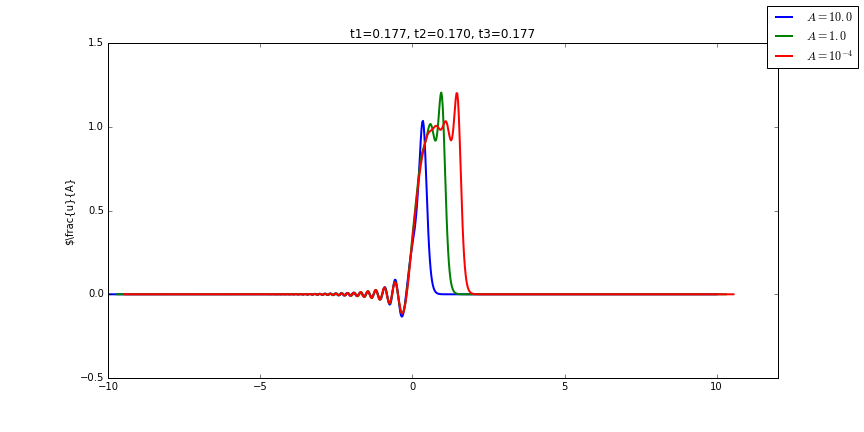
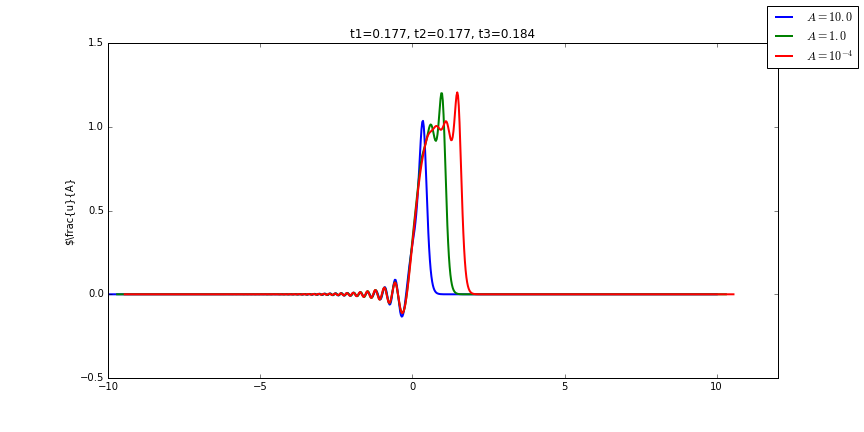
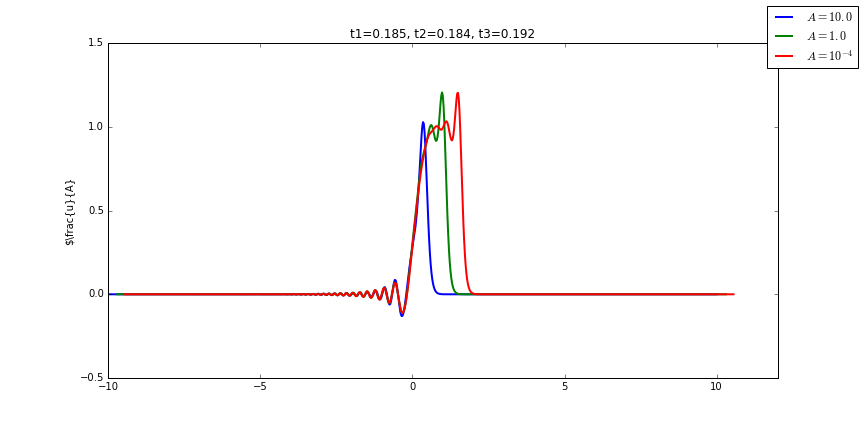
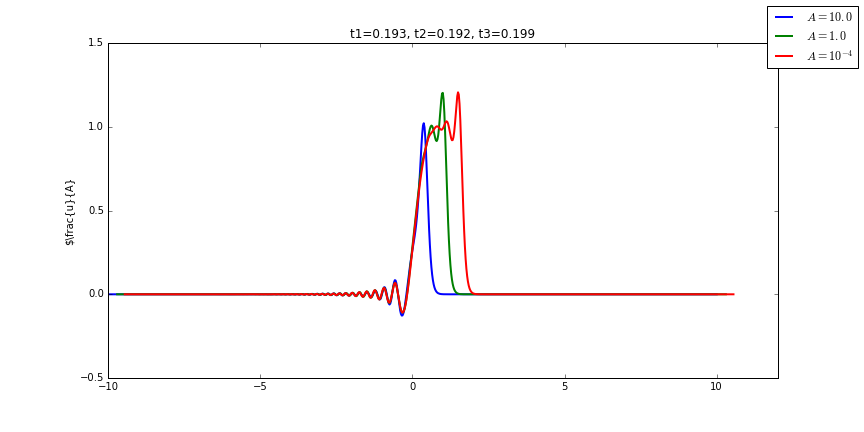
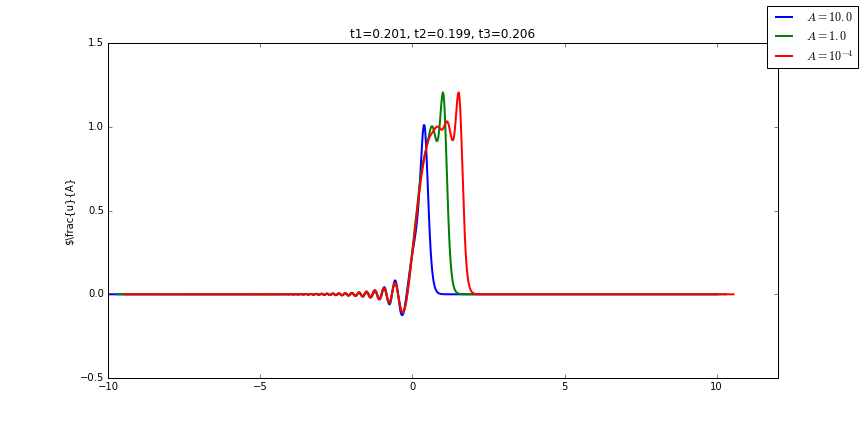
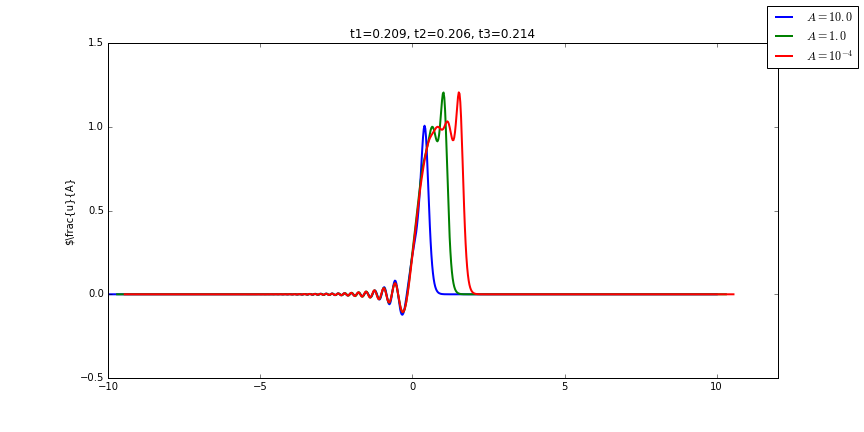
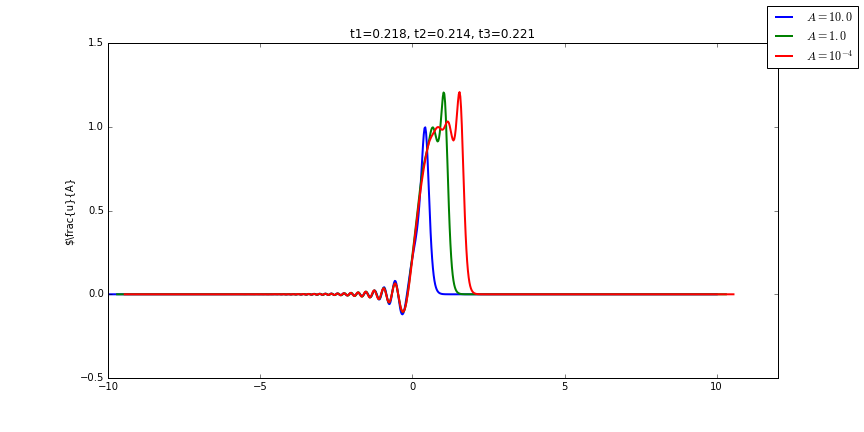
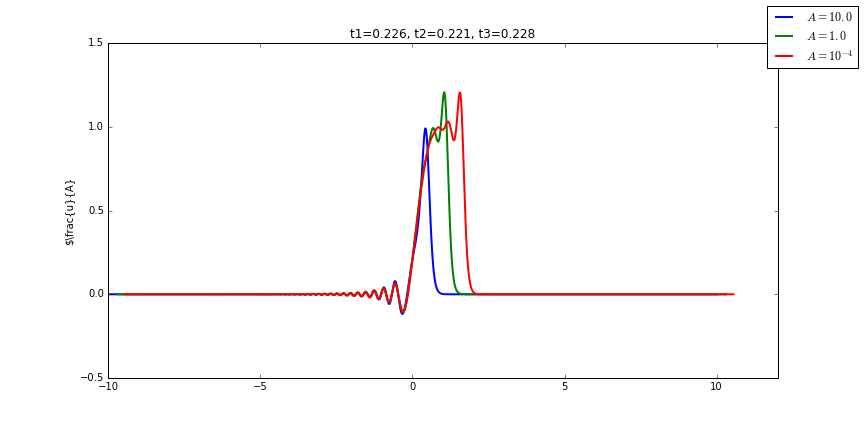
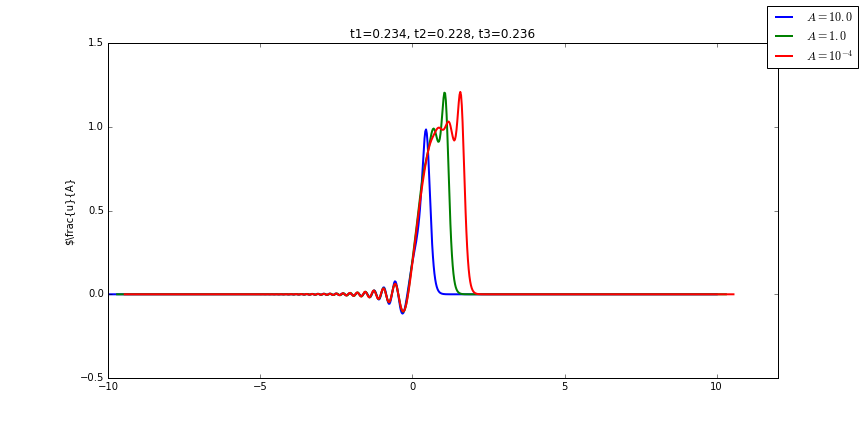
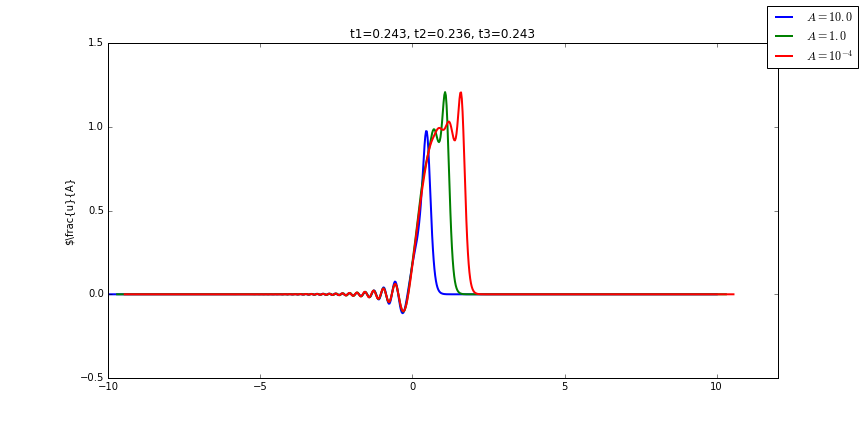
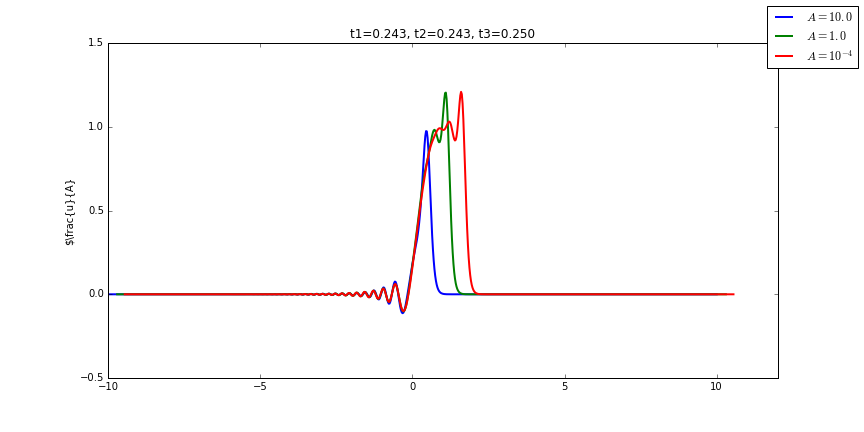
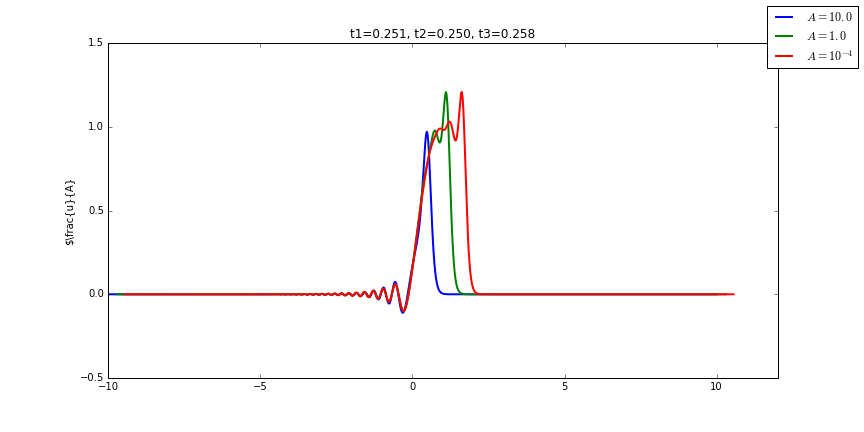
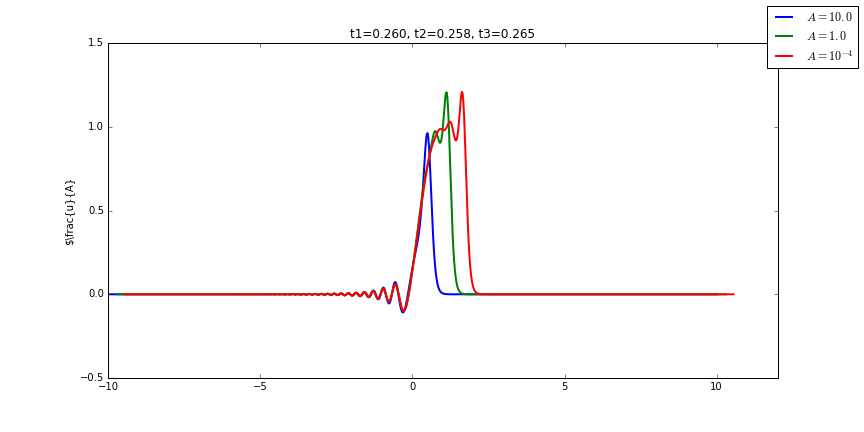
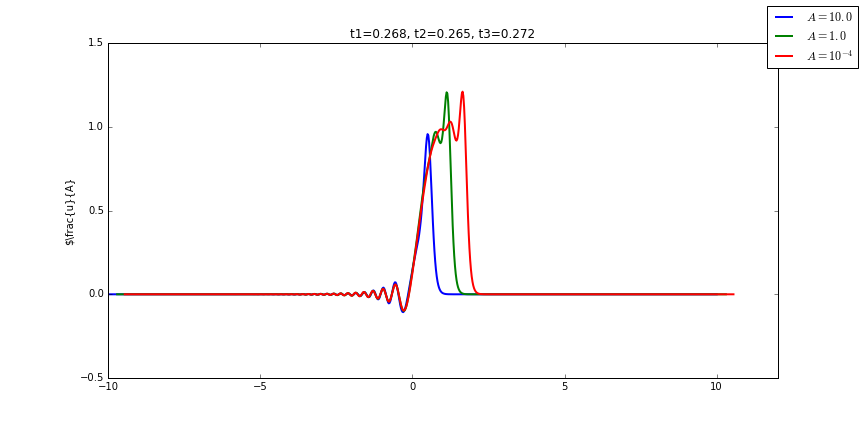
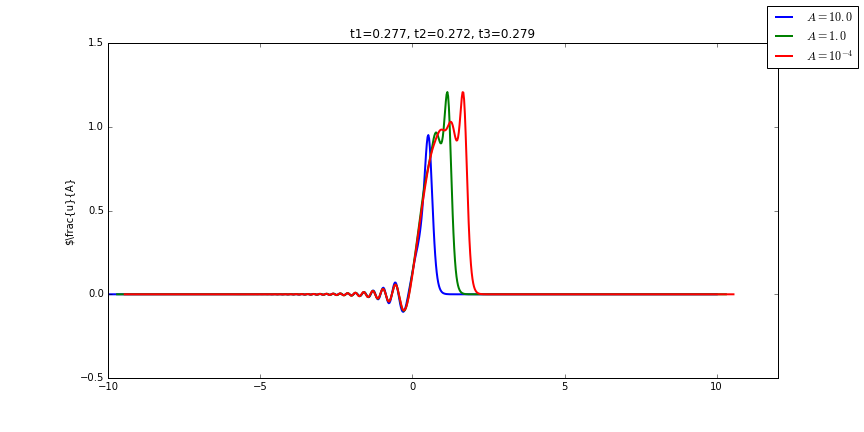
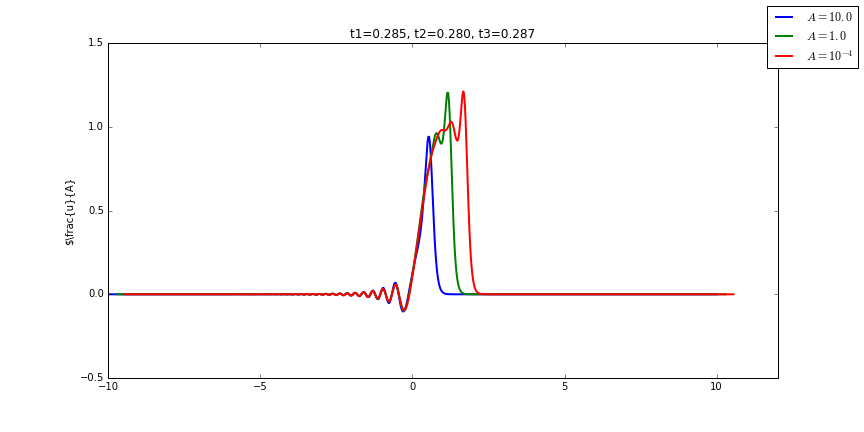
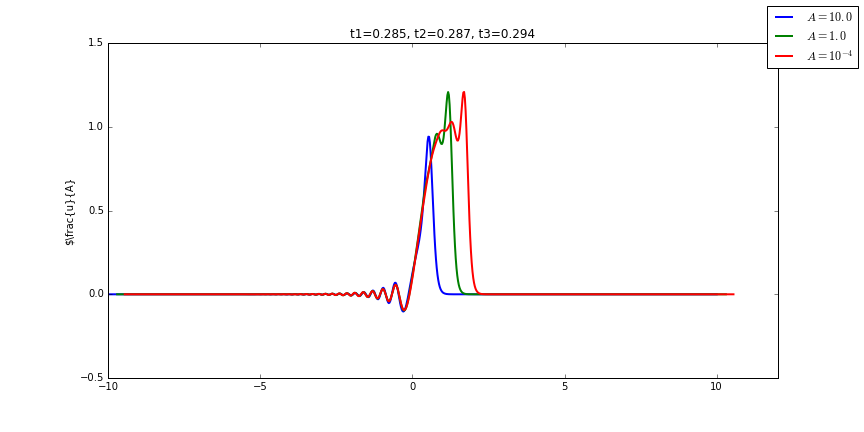
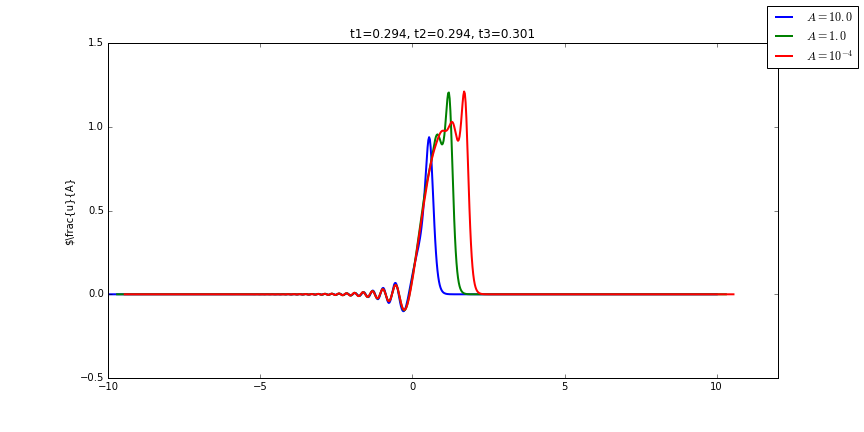
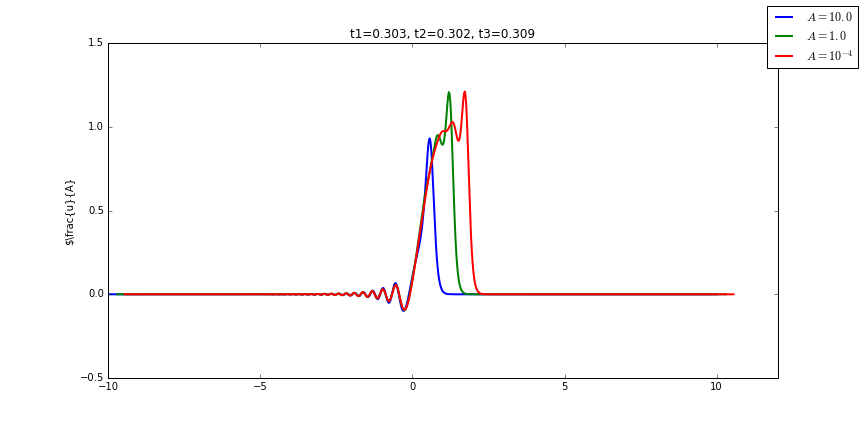
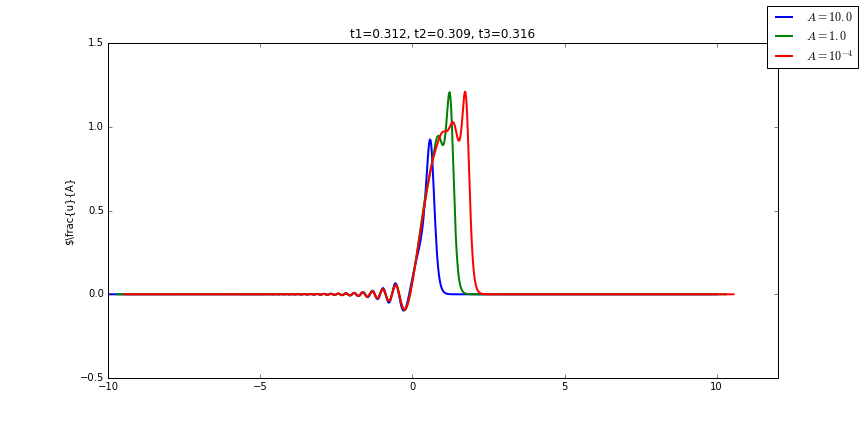
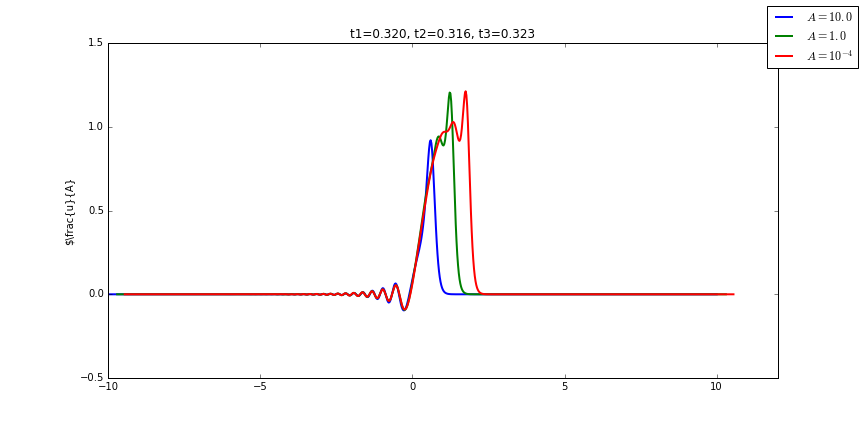
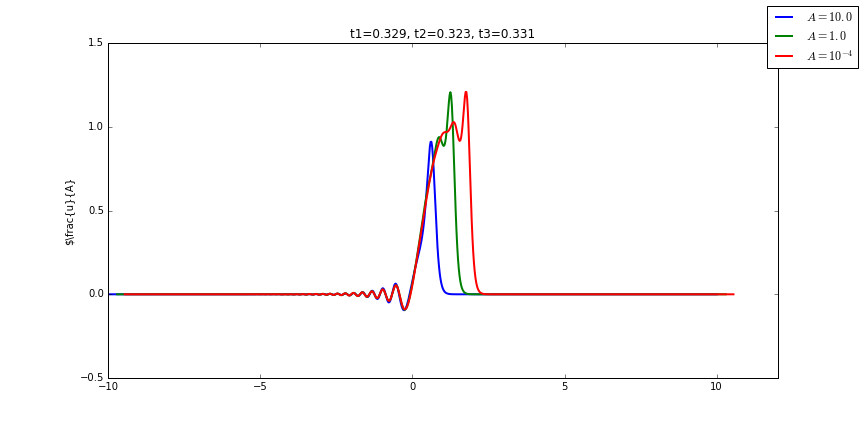
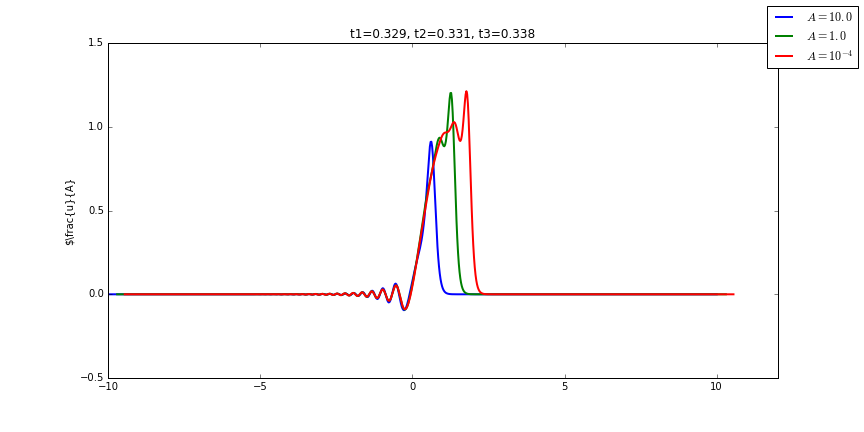
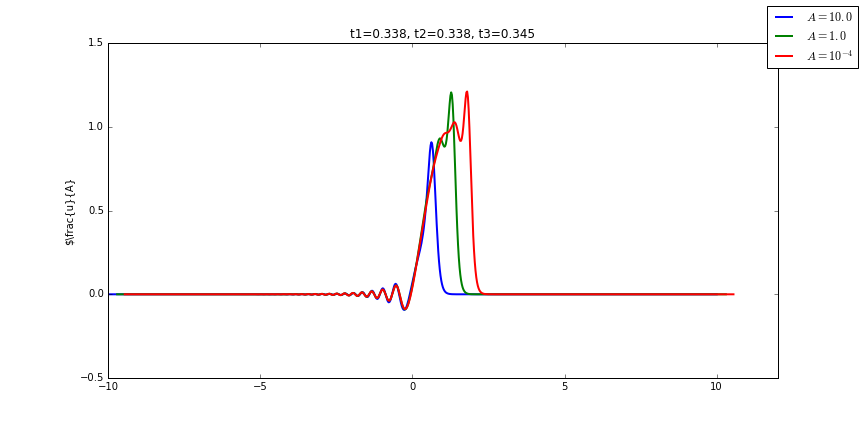
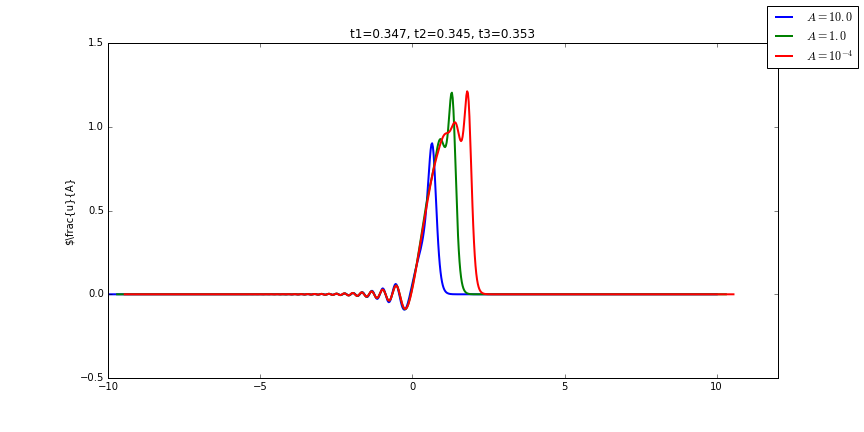
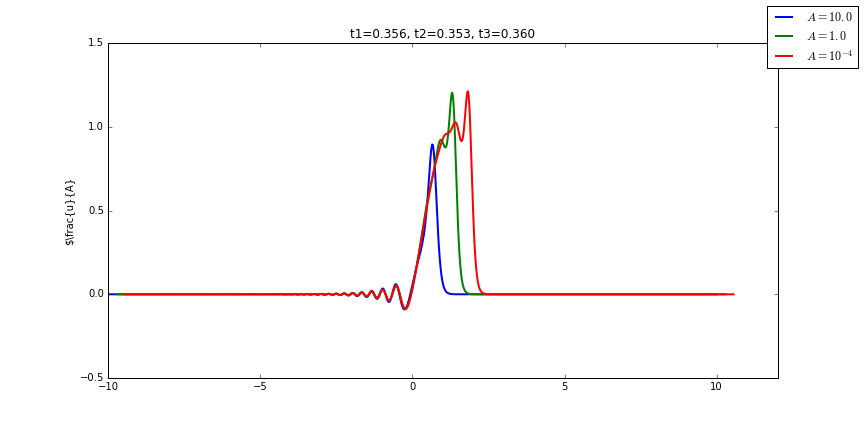
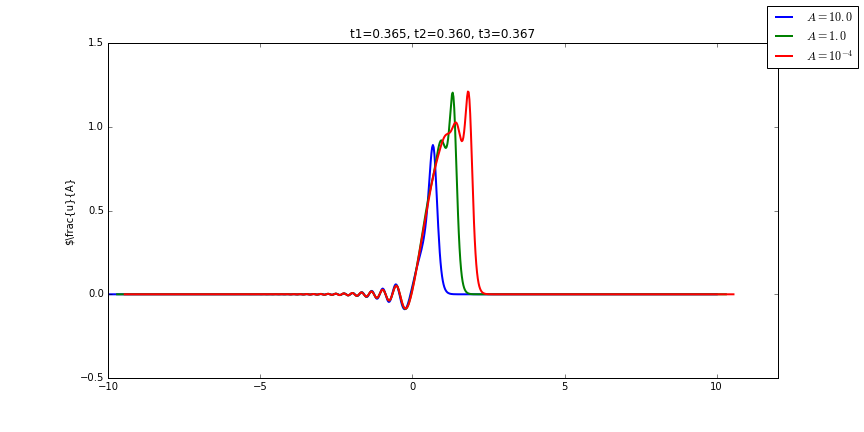
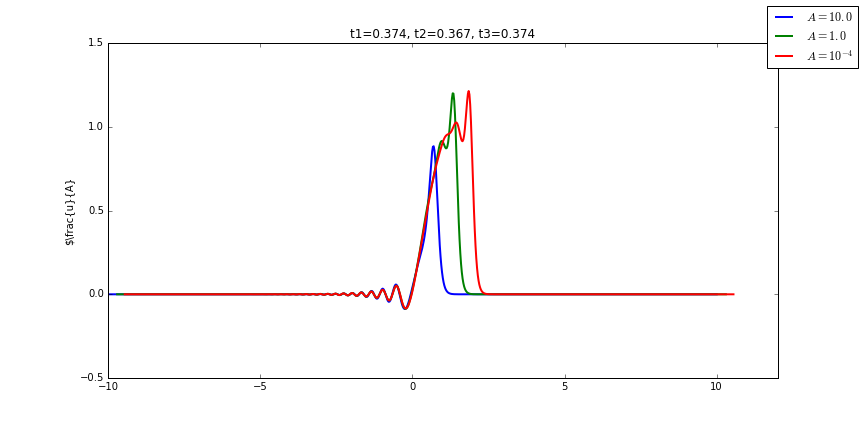
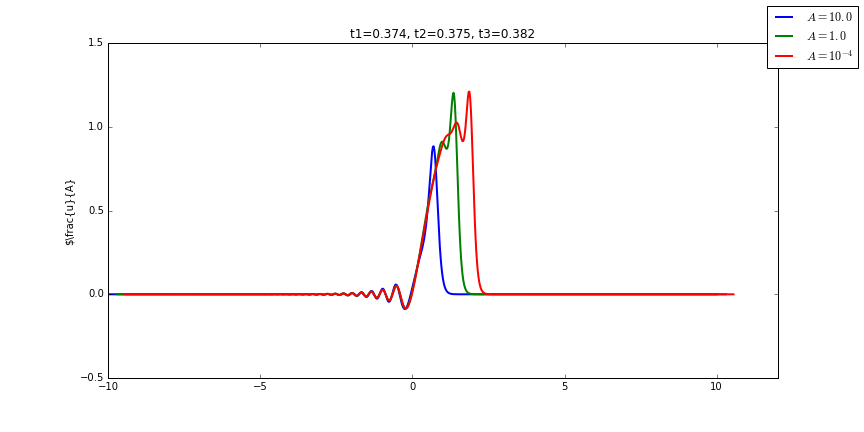
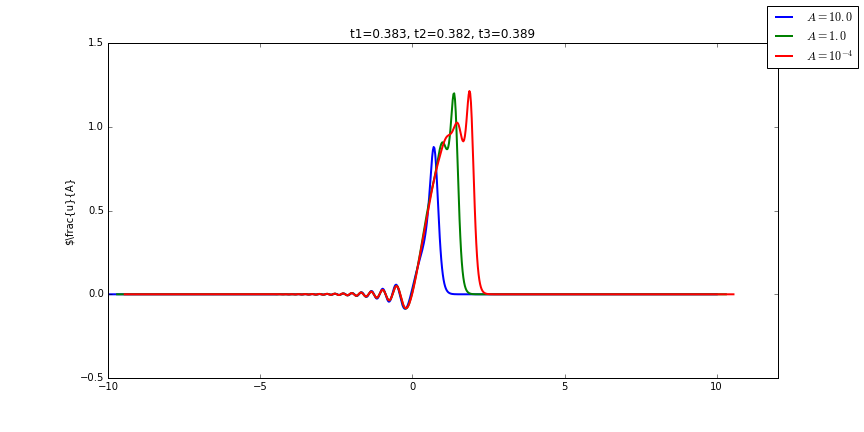
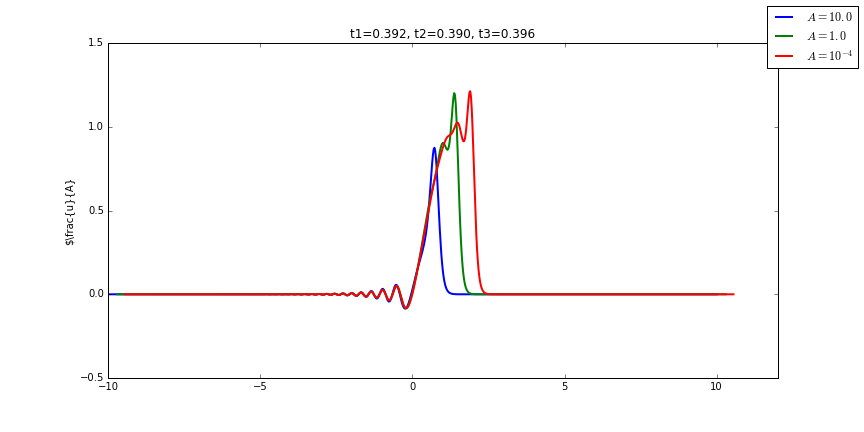
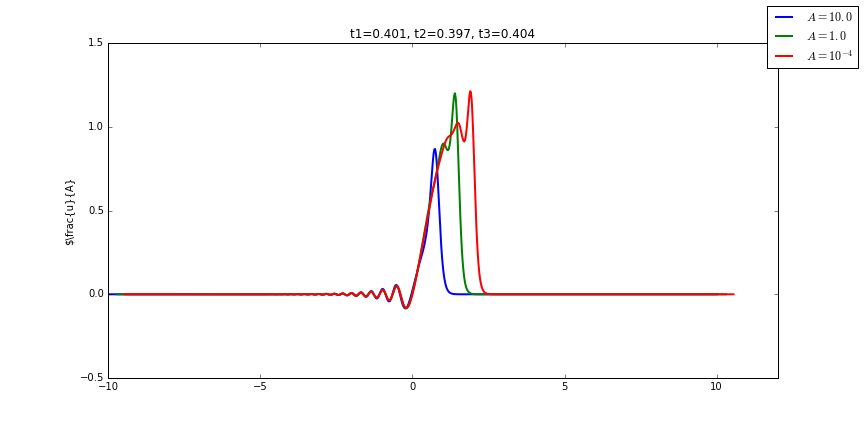
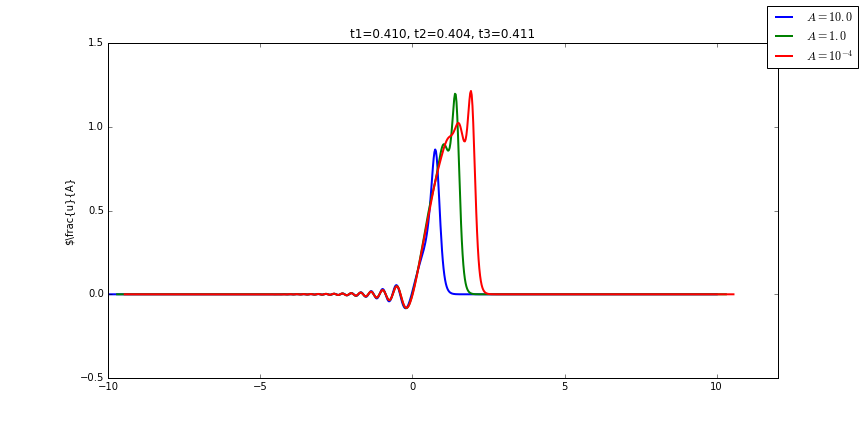
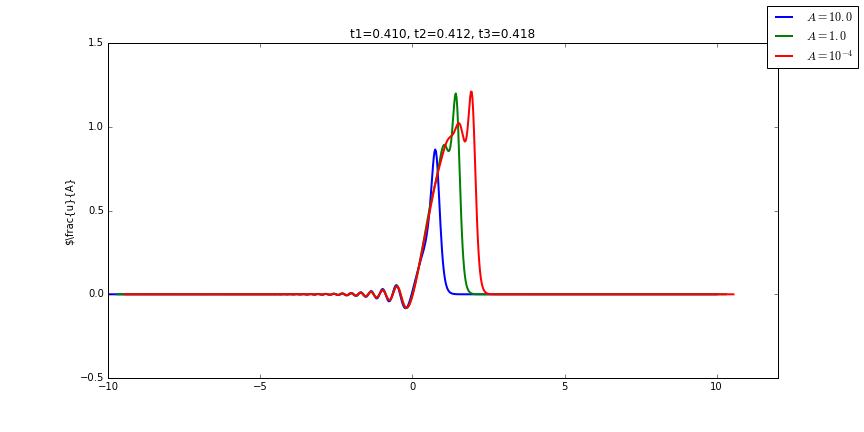
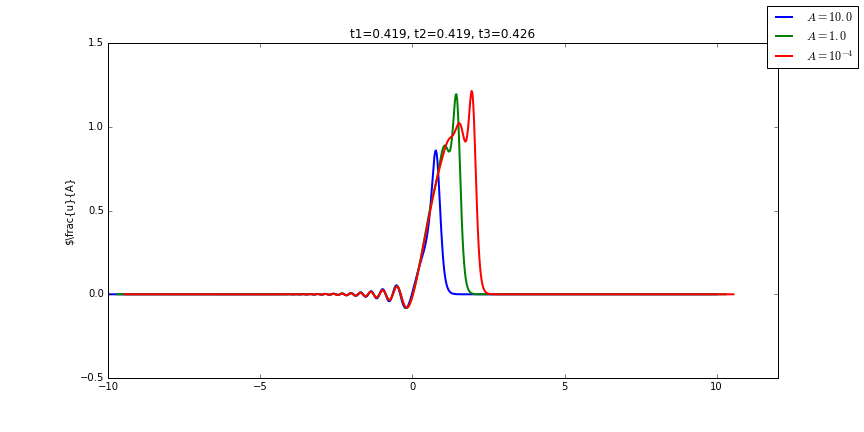
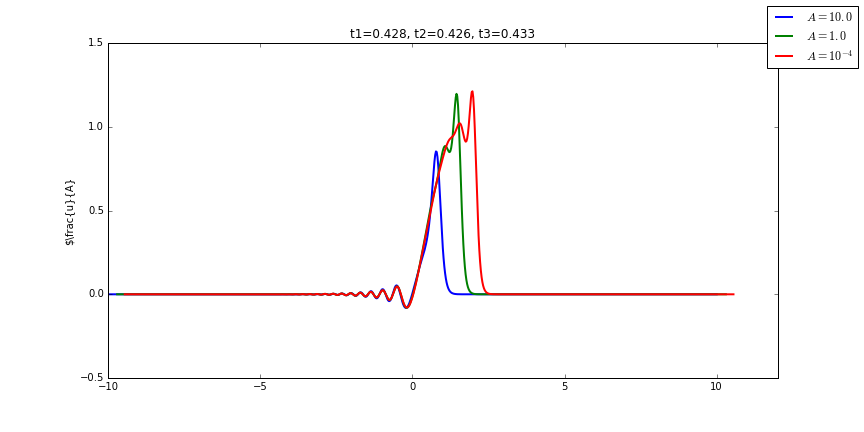
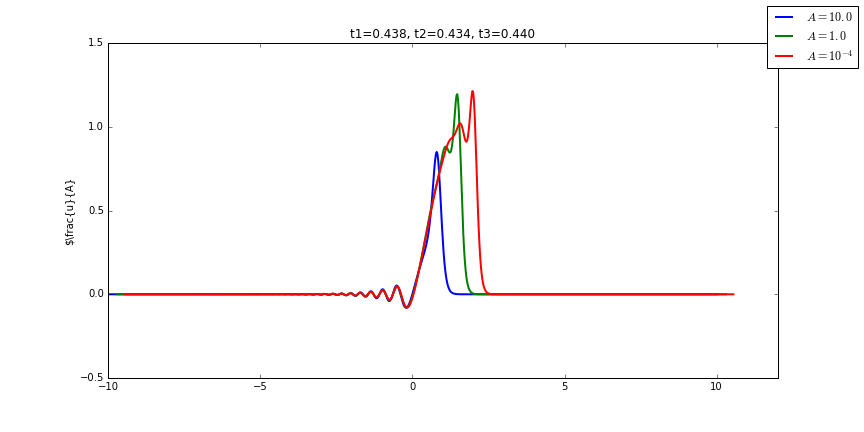
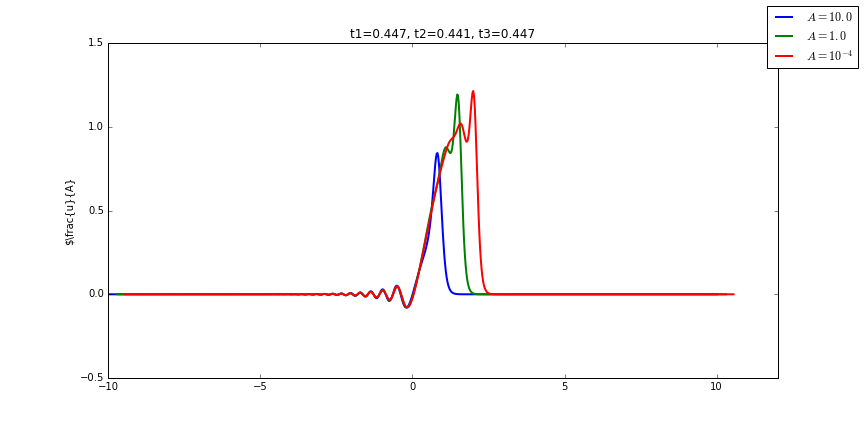
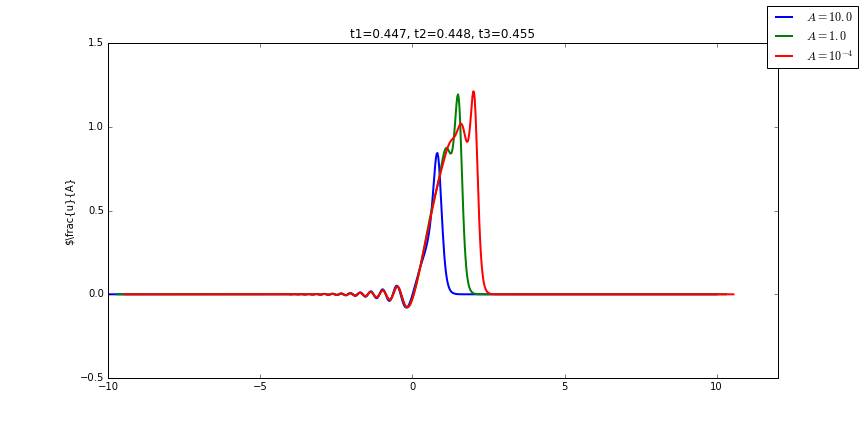
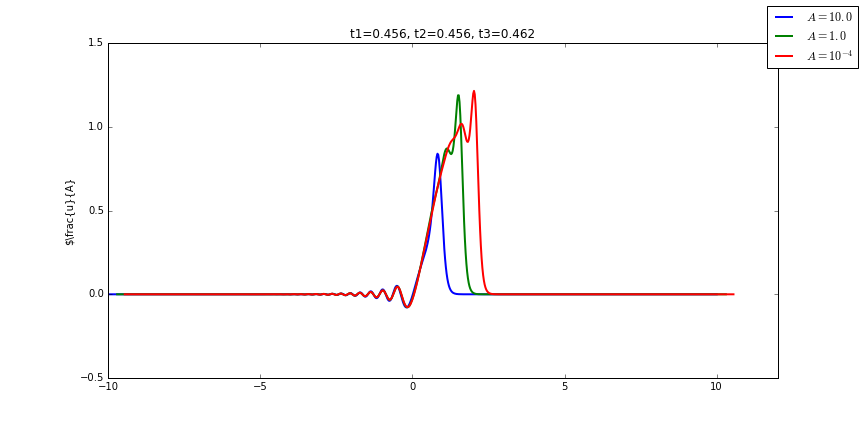
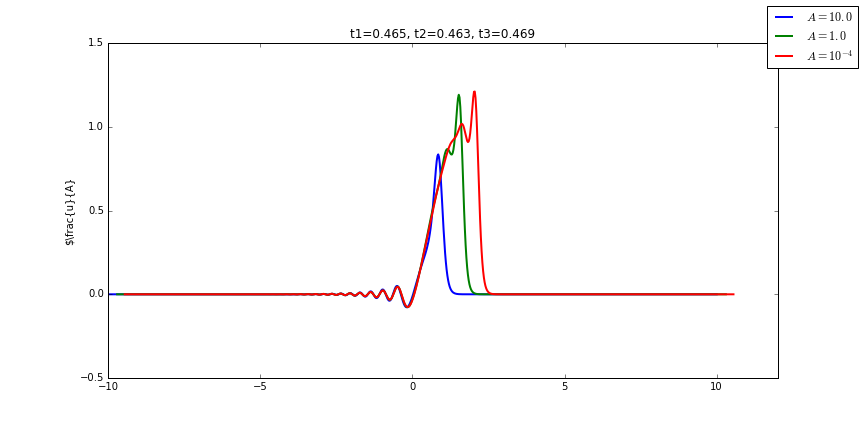
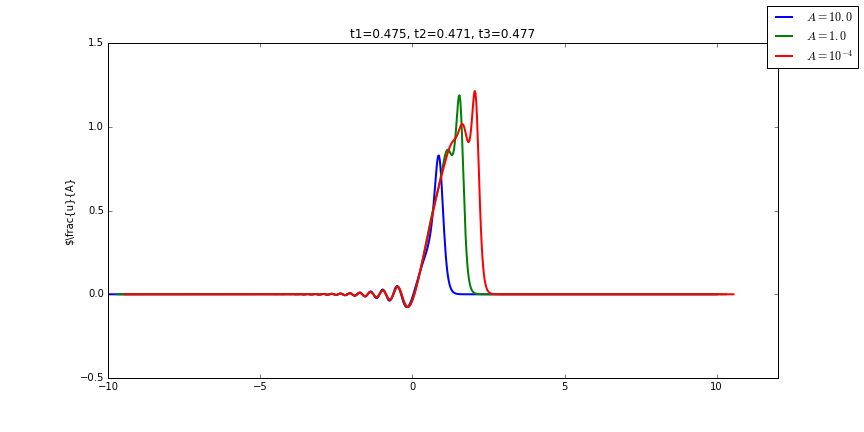
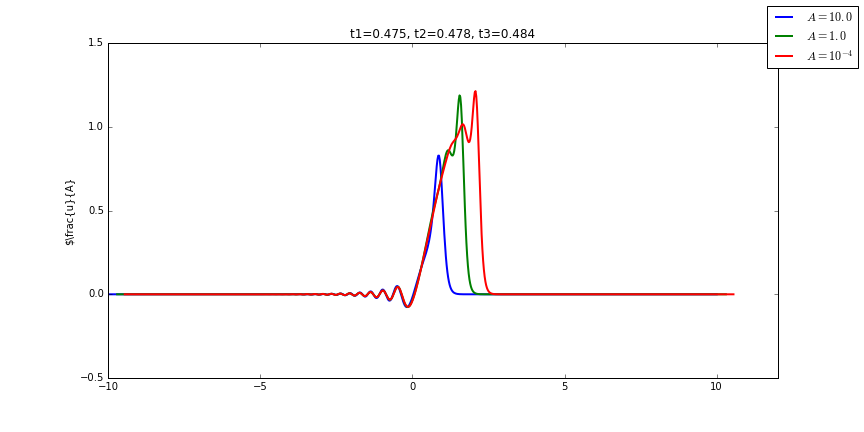
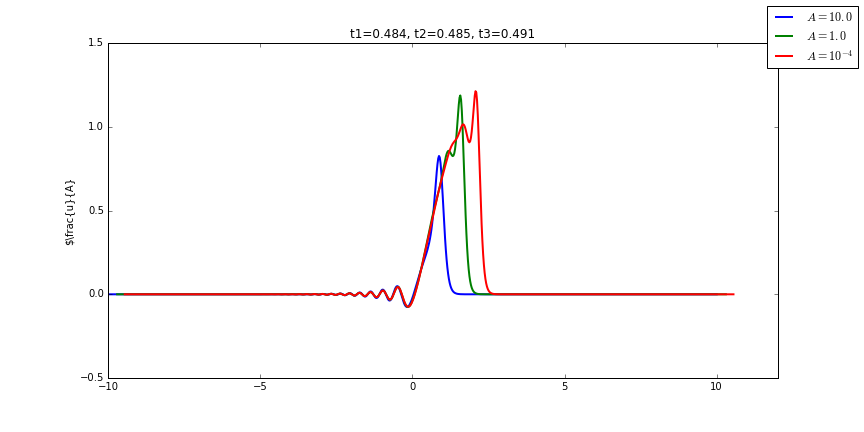
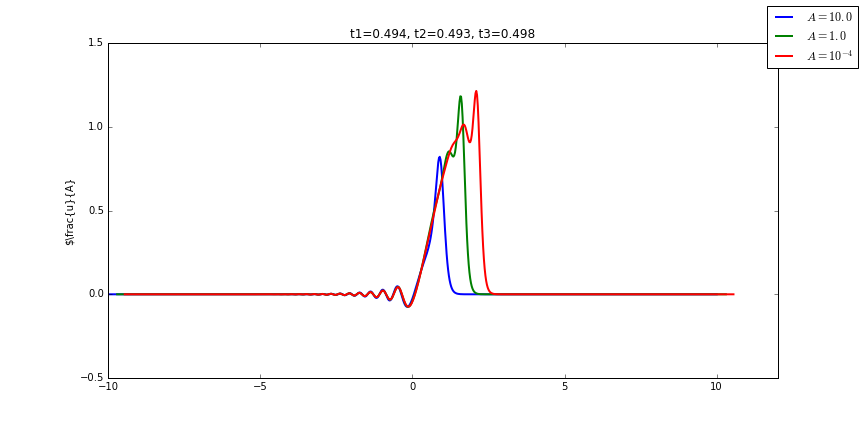

In [21]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(xmin, xmax+2), ylim=(-0.5, 1.5))
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
ax.set_ylabel(r'$\frac{u}{A}')
title = ax.set_title(r'$t=0.0 s$')
fig.legend((line1, line2, line3),(r'$A=10.0$',r'$A=1.0$', r'$A=10^{-4}$'),loc=0)

def animate(i):
    i1 = np.where(t1<=t3[i])[0][-1]
    i2 = np.where(t2<=t3[i])[0][-1]
    line1.set_data(x, u1[:,i1]/1.0)
    line2.set_data(x+(0.5-0.2), u2[:,i2]/1.0)
    line3.set_data(x+(0.75-0.2), u3[:,i]/1.0)
    title.set_text('t1=%.3f, t2=%.3f, t3=%.3f'%(t1[i1],t2[i2],t3[i]))
    #ax.annotate(r'$t = %f $' %tall[i],(1,1))
    return line1,line2

animation.FuncAnimation(fig, animate, frames=t3.shape[0]-1, interval=150)

## Criteria for checking the validity of the test cases

In order to correctly the physical phenomena involved in the KdV equation, the initial solution must must satisfy the assumptions made in the derivation of the model. The tests realized above were made to analyze the influence of the characteristics of the wave on the nonlinear and dispersive effects; therefore, the amplitude and the wavelength must be properly chosen. A criteria was developed for this purpose, as described below :

We will seek to write the KdV equation in the following dimensionless and scaled form, as described in BBM article ([BBM])

$U_T + U_X + \frac{\epsilon}{2} (U^2)_X + \epsilon\alpha^2U_{XXX} = 0$

### Relation to the physical parameters

In a first moment, we will try to link the physical parameters involved in the model. Following [Senthilkumar], the dimensional form of the KdV equation is

$u^*_{t^*} + c_0u^*_{x^*} + \frac{3}{4}\frac{c_0}{h_0}({u^*}^2)_{x^*} + \frac{1}{6}c_0h_0^2u^*_{x^*x^*x^*} = 0$

where the $\cdot^*$ denotes the physical variables, $h_0$ the undisturbed water depth for flat bottom and $c_0 = \sqrt{gh_0}$  the long wave speed.

Performing the same changes of variables done by [BBM], we obtain the following dimensionless and scaled form : 

$U_T + U_X + \frac{3\epsilon}{4b} (U^2)_X + \frac{h_0^2\epsilon}{6}U_{XXX} = 0$

where $b$ is a constant such that $bu^* = \epsilon U$

Comparing the two dimensionless, scaled equations, we obtain

$b = \frac{3}{2}$

$\alpha^2 = \frac{h_0^2}{6}$


### Choice of the wave amplitude

From $bu^* = \epsilon U$, with $U$ of unit order magnitude, the physical variable is written as $u^* = \frac{2}{3}\epsilon U, \ (\epsilon > 0)$, where $\frac{2}{3}\epsilon$ is the wave amplitude (as done in the scale study). Accordingly to [BBM], the nonlinearity in the KdV equation is valid for $\epsilon \ll 1$. Therefore, $\epsilon$ will be chosen taking in account this condition.

## Choice of the wavelength

[BBM] derives the dispersive term of the KdV equation assuming that, for a wavenumber $\kappa$ suffiicently small, the wave speed $c(\kappa) = c_0 + c_0 \sum_{n=1}^{\infty}A_n\epsilon^n\kappa^{2n}$ can be approximated by $c(\kappa) = c_0(1-\kappa^2\alpha^2)$,

and, as a consequence, the operator containing the dispersive effect,

$L_\epsilon U = U + \sum_{n=1}^{\infty}(-1)^nA_n\epsilon^n\partial^{2n}_XU$

can be truncated at first order in $\epsilon$, giving

$L_\epsilon U = U - \epsilon \alpha^2U_{XX}$

That means that we must assure that the terms for the higher derivatives (for $n > 1$) are small enough to be neglected. Firstly, [BBM] assumes that all this derivatives have have an order of magnitude 1. Secondly, also accordingly to [BBM], the following form is applicable to surface waves : 

$c(\kappa) = c_0 \left(\frac{tanh(\kappa h_0)}{\kappa h_0}\right) = c_0 \left(1 - \frac{1}{6}(\kappa h_0)^2 + \frac{19}{360}(\kappa h_0)^2 + ... \right) $

showing that we must choose $\kappa h_0 \ll 1$

Denoting $\lambda$ as the wavelength, and choosing a constant $B$ such that $\kappa h_0  =  B \ll 1$, it follows that $h_0 = \frac{B\lambda}{2\pi}$, and, from the relation $\alpha^2 = \frac{h_0^2}{6}$, we get $\alpha^2 = \frac{B^2\lambda^2}{6(2\pi)^2}$.

## The criteria

In resume, the proposed criteria to construct the initial data is : 

* Adopt a water depth $h_0$ (e.g. from the data)
* Choose a wave amplitude  $A = \frac{2}{3}\epsilon$, with $\epsilon \ll 1$
* Choose a wavelength $\lambda$ such that $\kappa h_0 = \frac{2\pi}{\lambda}h_0 = B \ll 1$

In [51]:
h0 = 1
A = 0.001
B = .01
wvl = 2*np.pi*h0/B

L = 2*wvl
xmin = -L
xmax = L
dx = 0.025
x = kdv.discretizeSpace(xmin,xmax,dx)
x.size

1006

In [52]:
u = np.zeros_like(x)
u = np.where( (x>=-.5*wvl)*(x<=.5*wvl), A, u)   #### Square wave not valid!!!!
#u = A*np.exp(-(x-0.)**2/wvl) 
# A = 10.0
# u = np.exp(-(x-xmax/2.0)**2/.01)  
u1, t1 = kdv.runRk4FVFourier(x,u,t0=0,tmax=0.5,a=1,b=1)


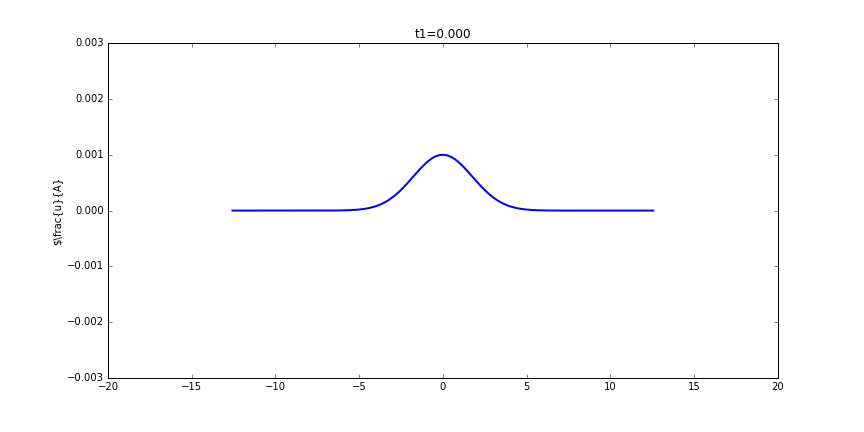
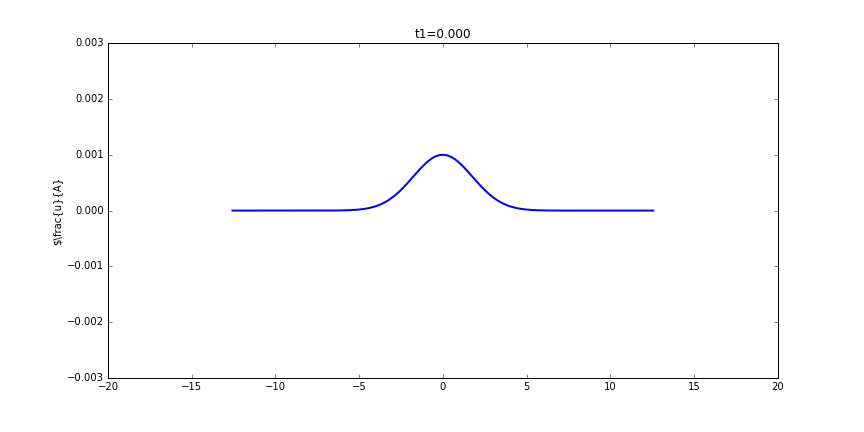
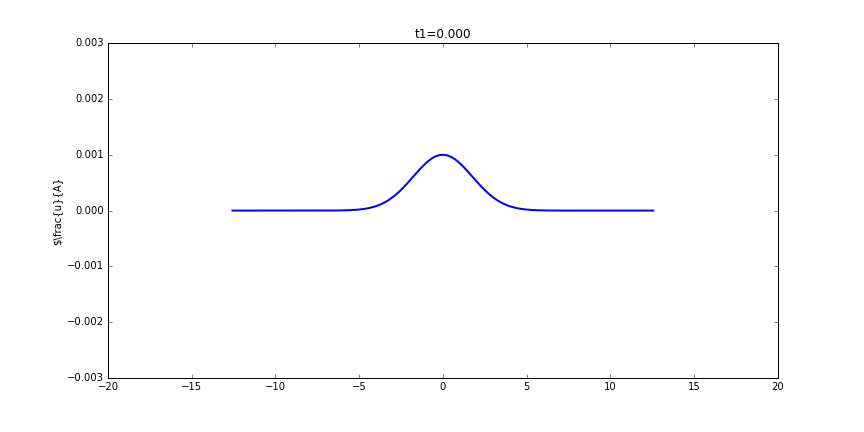
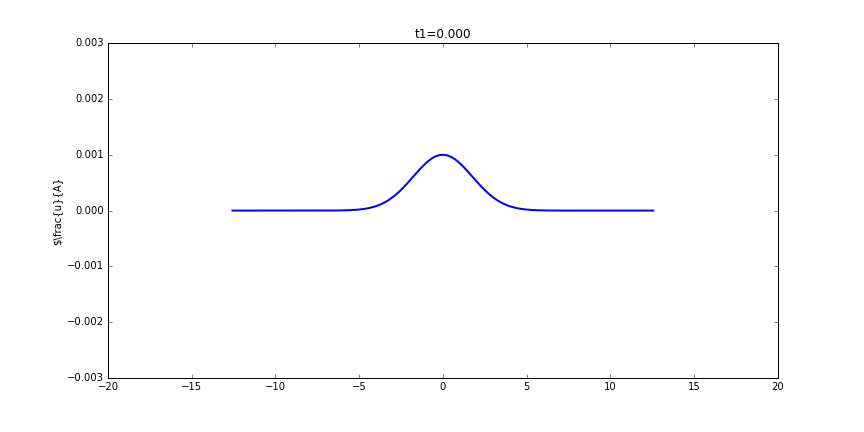
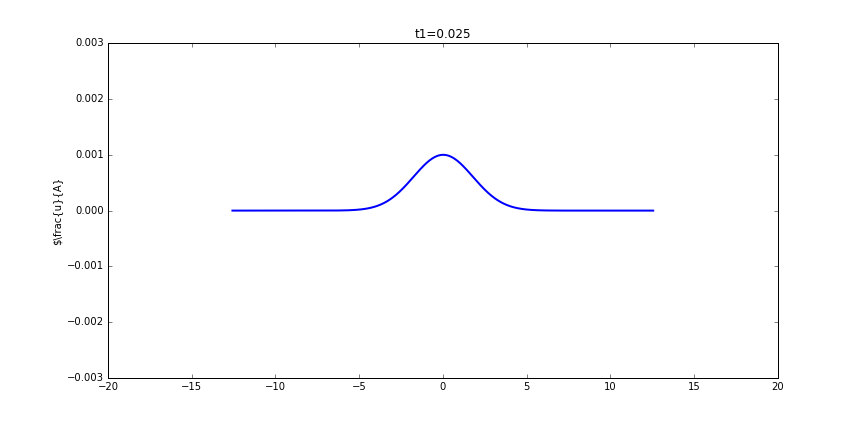
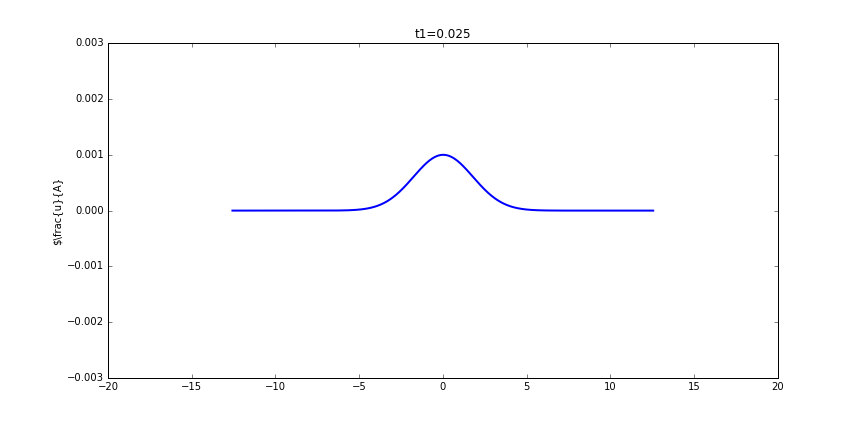
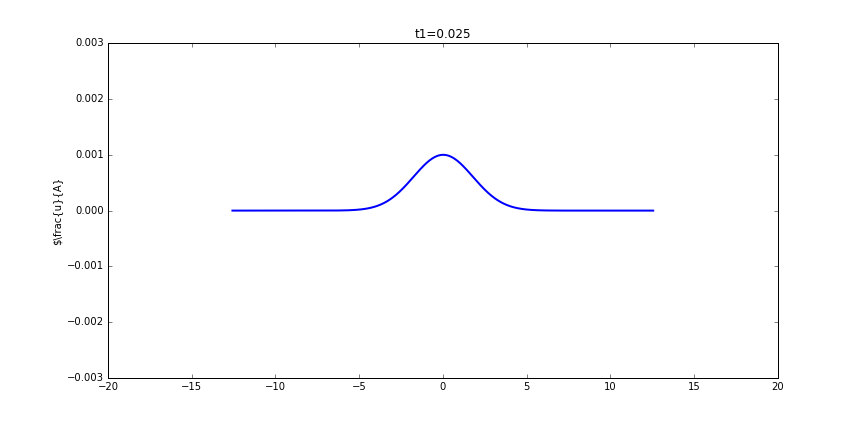
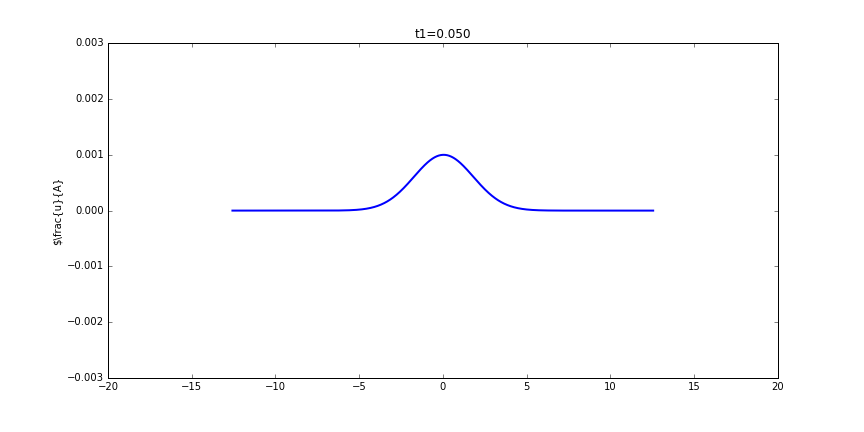
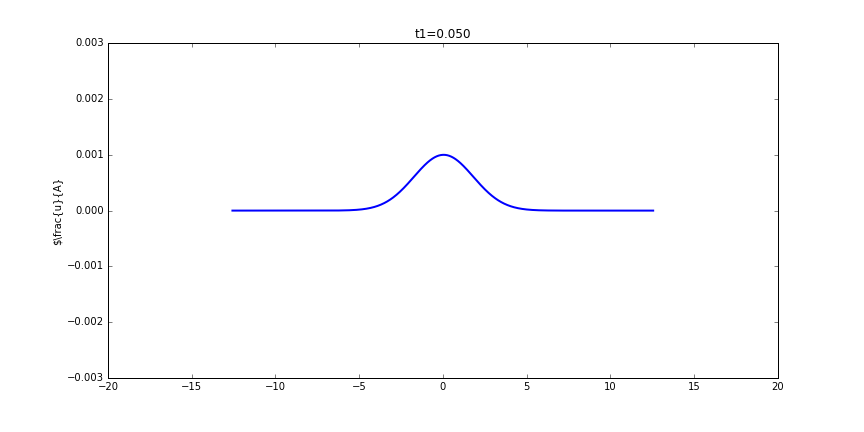
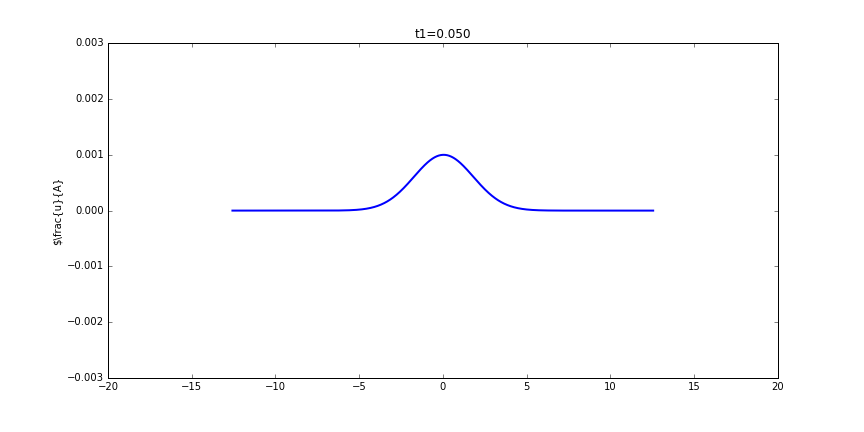
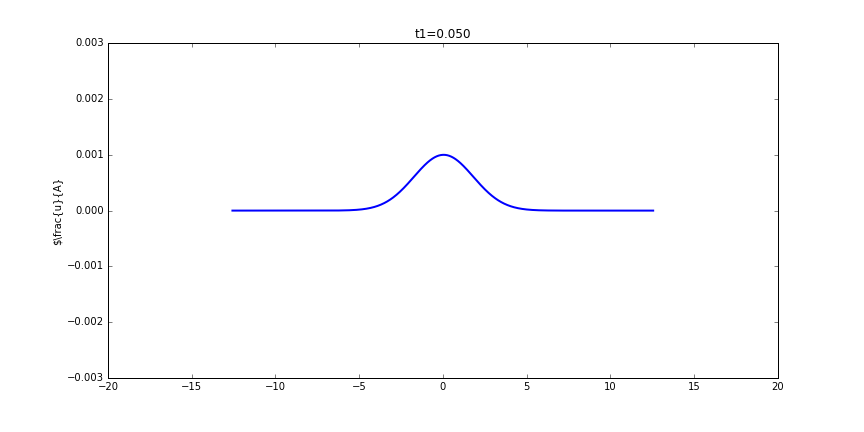
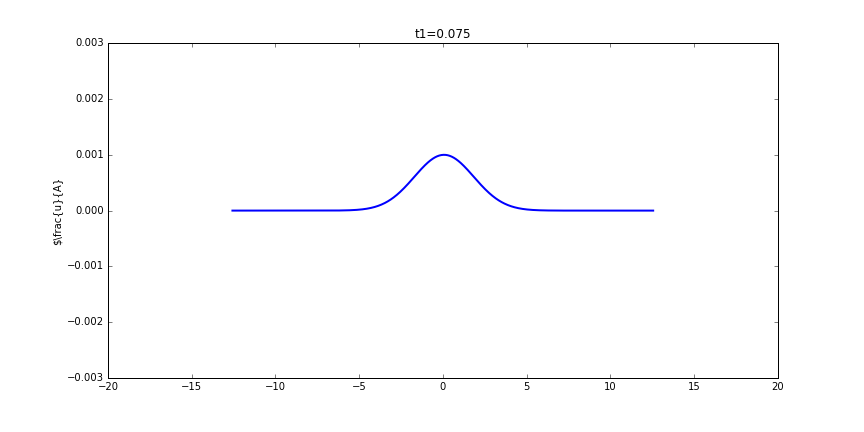
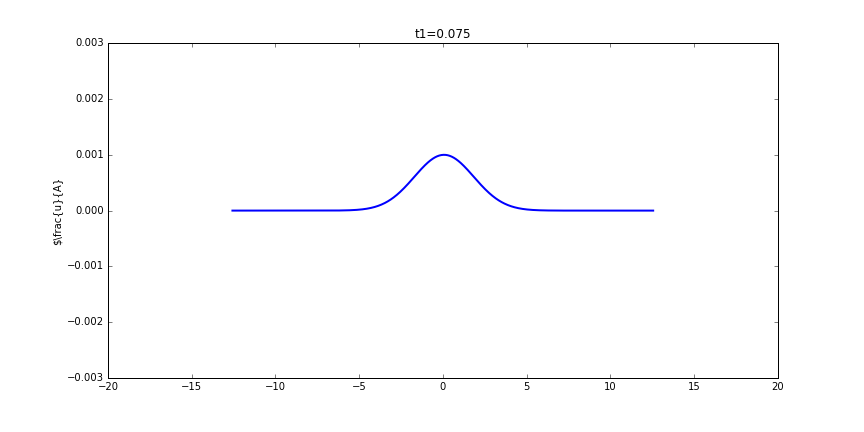
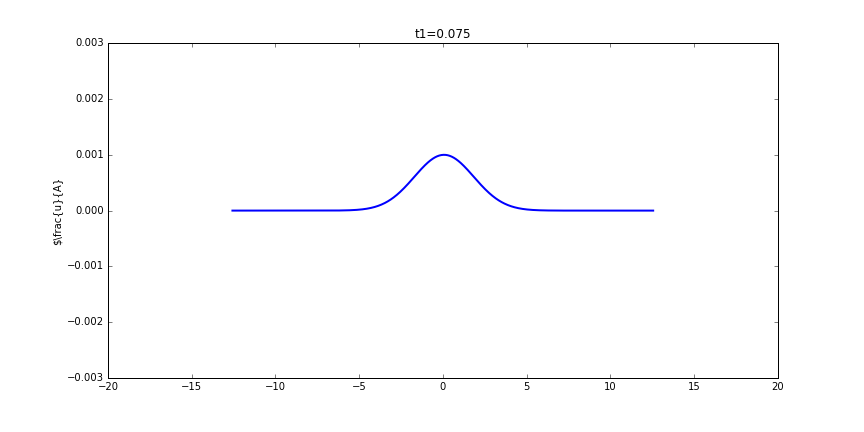
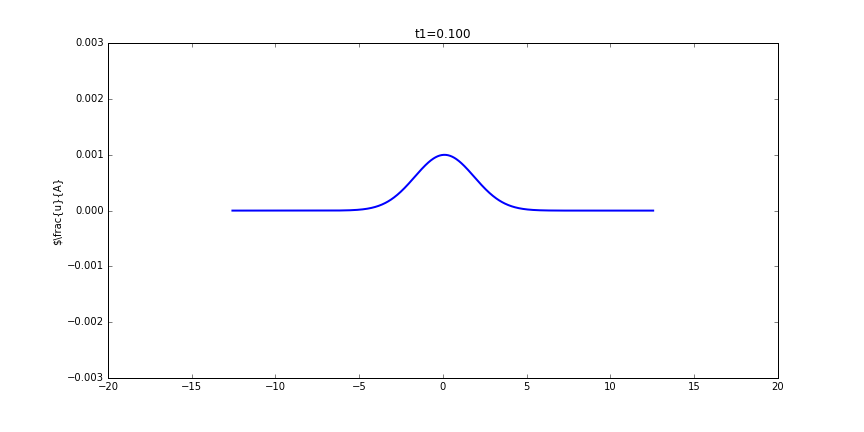
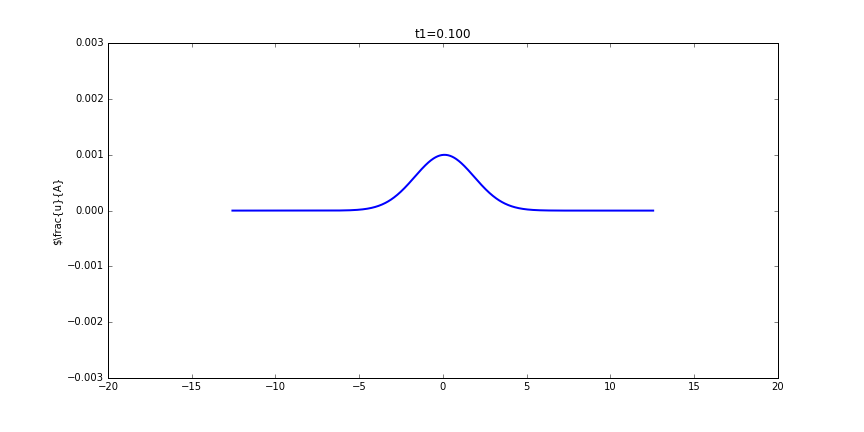
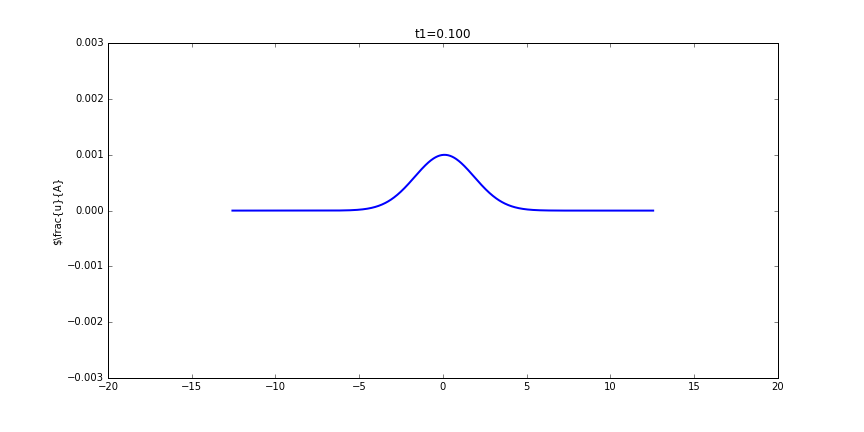
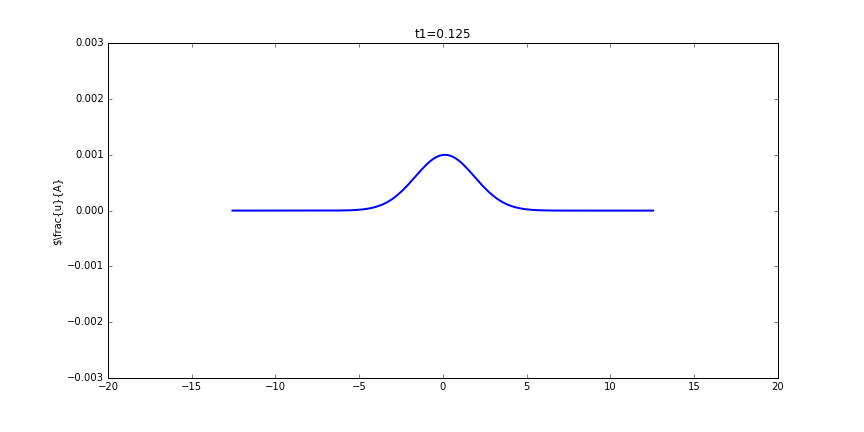
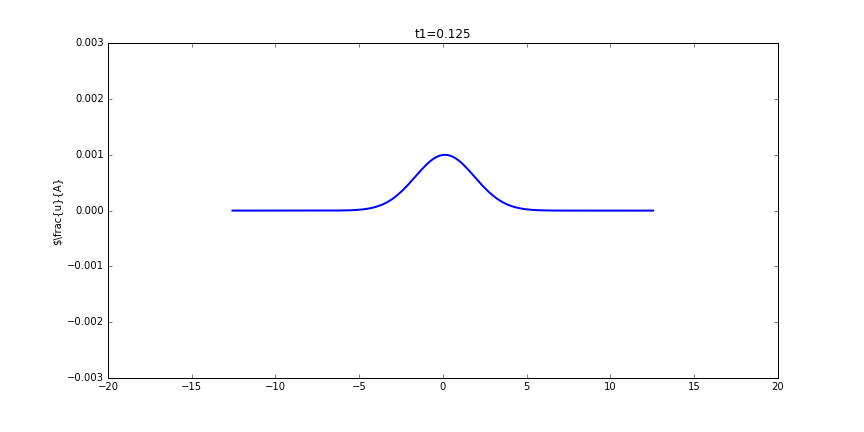
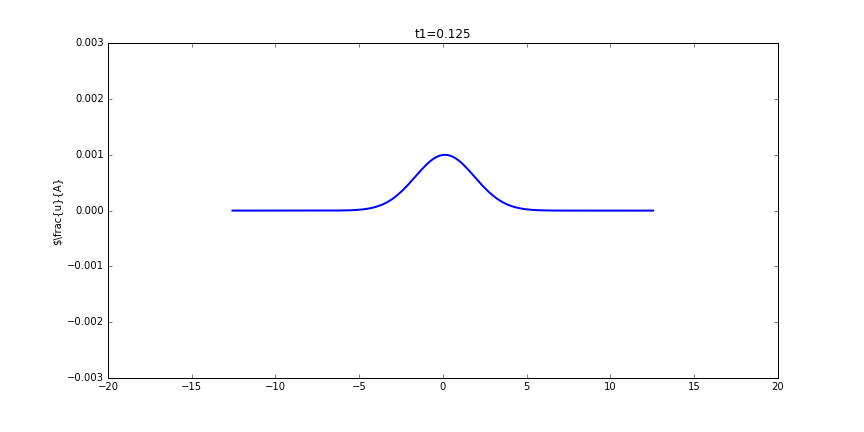
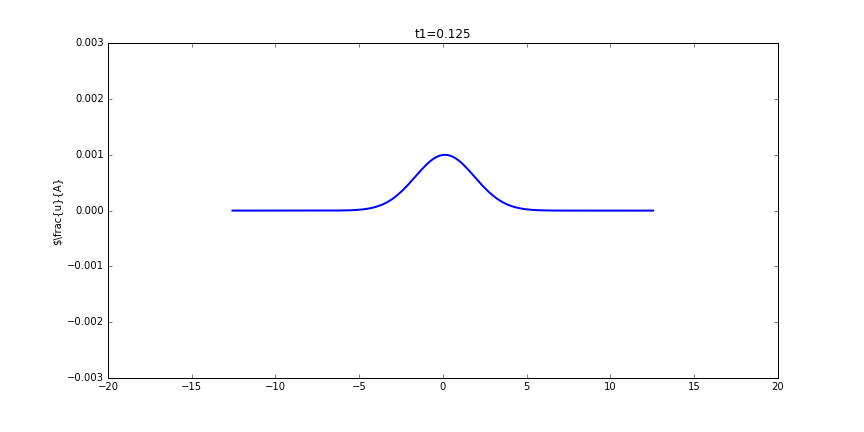
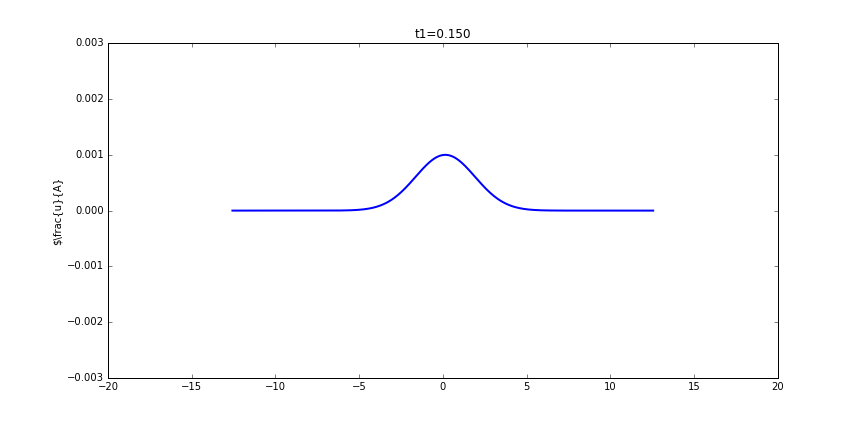
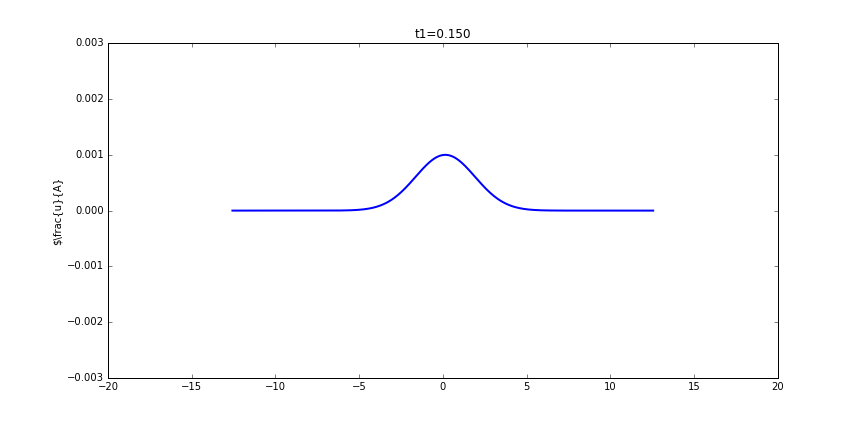
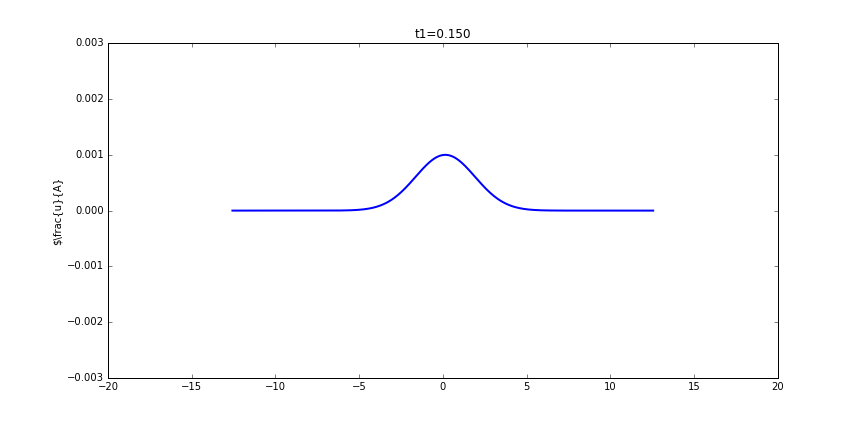
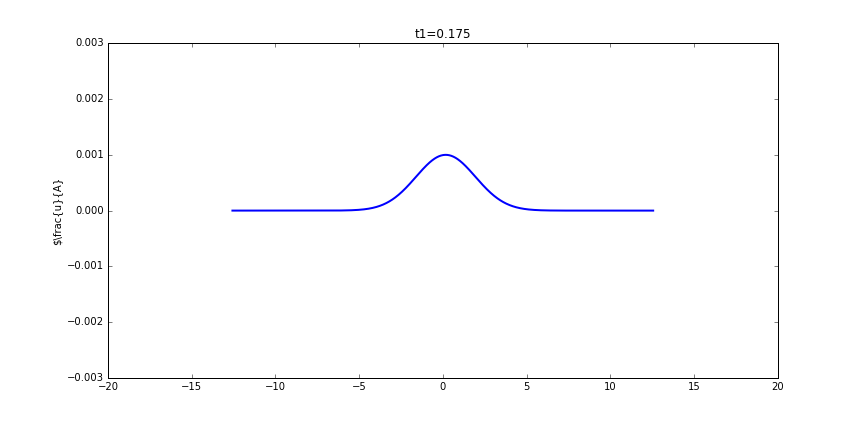
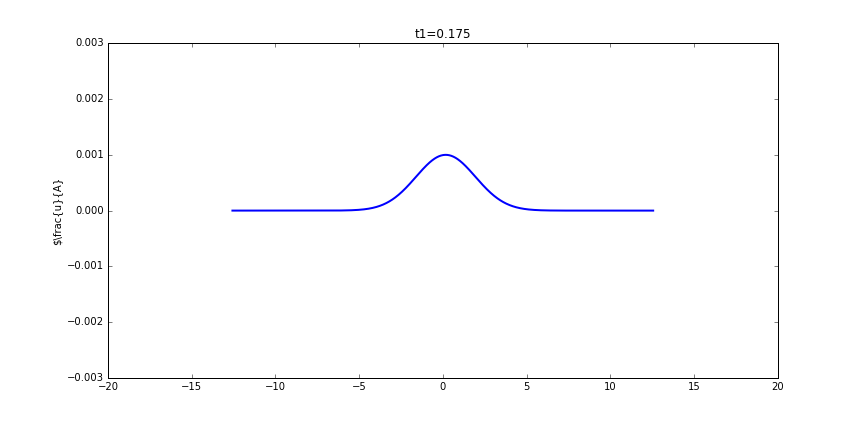
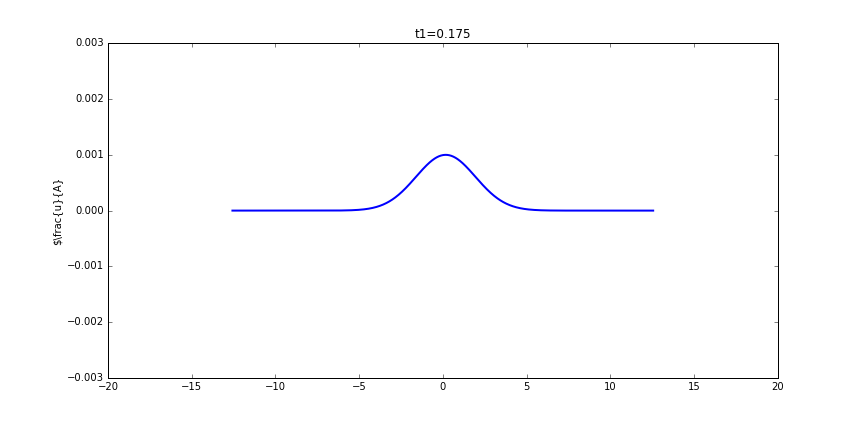
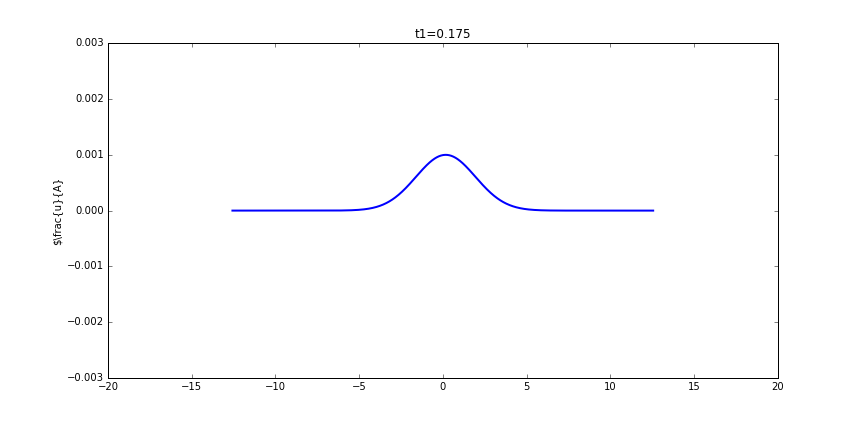
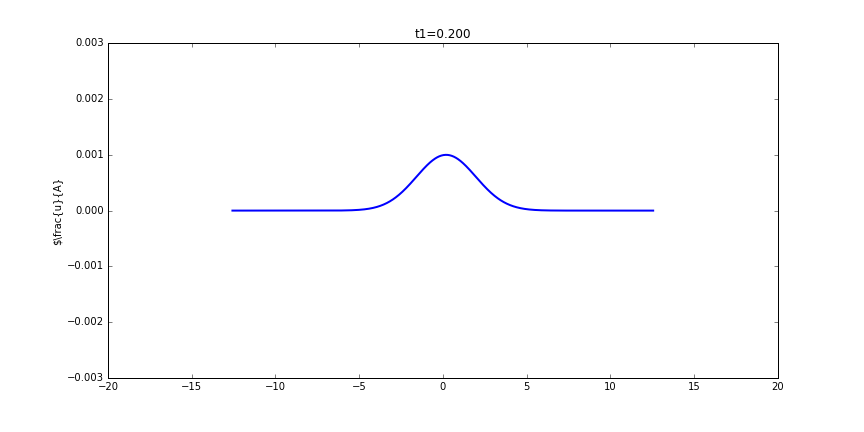
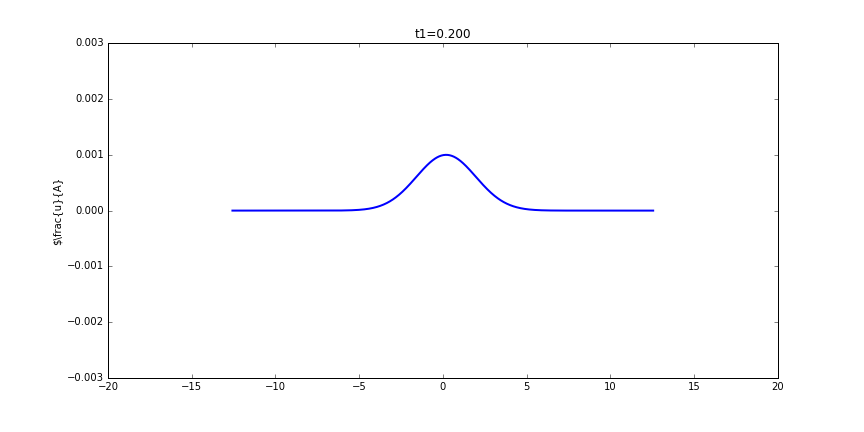
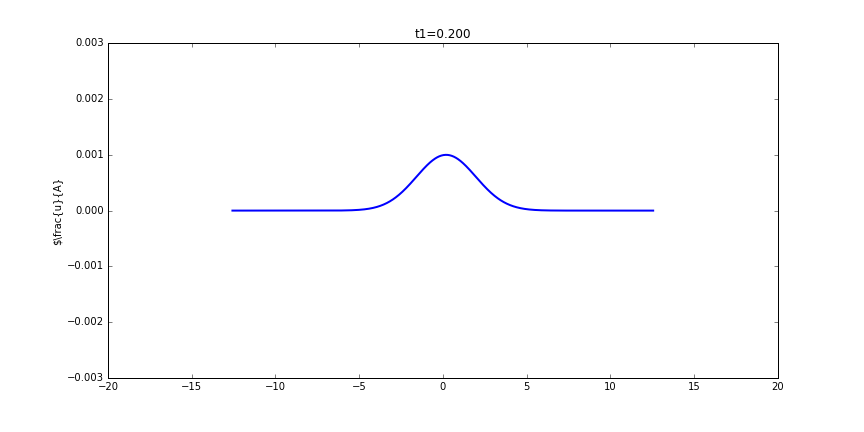
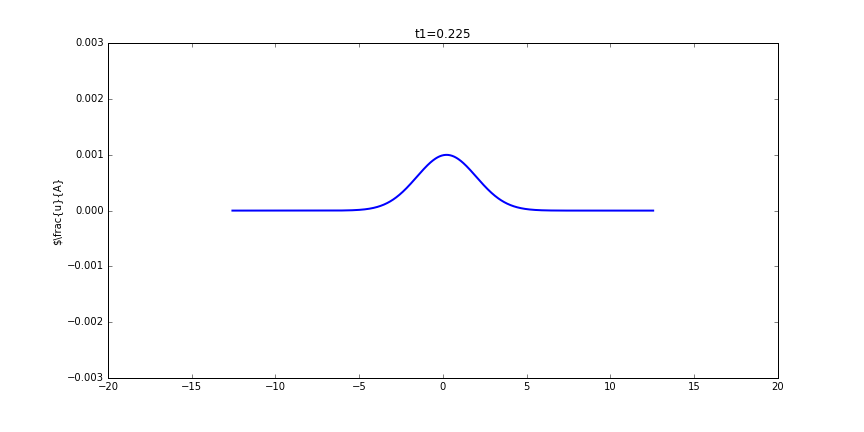
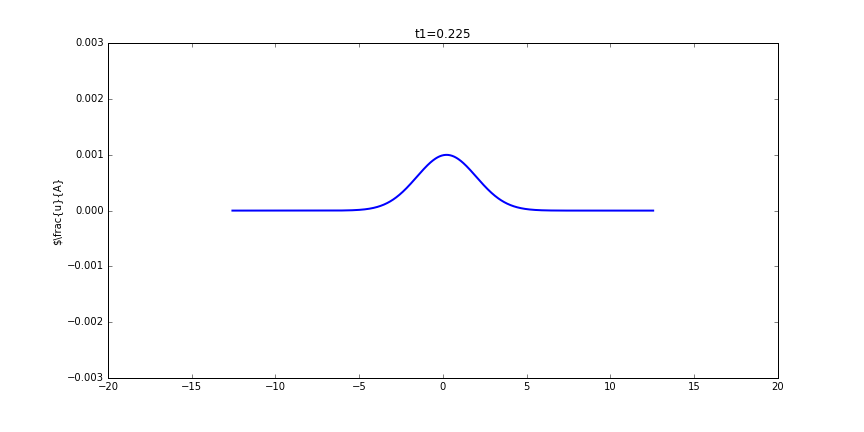
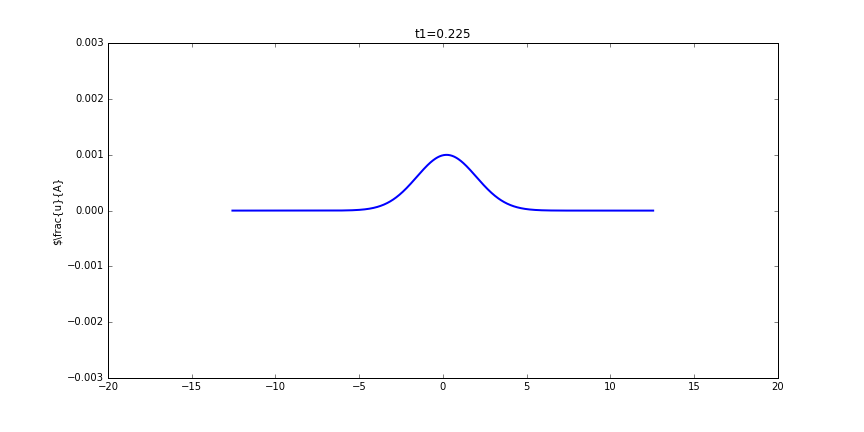
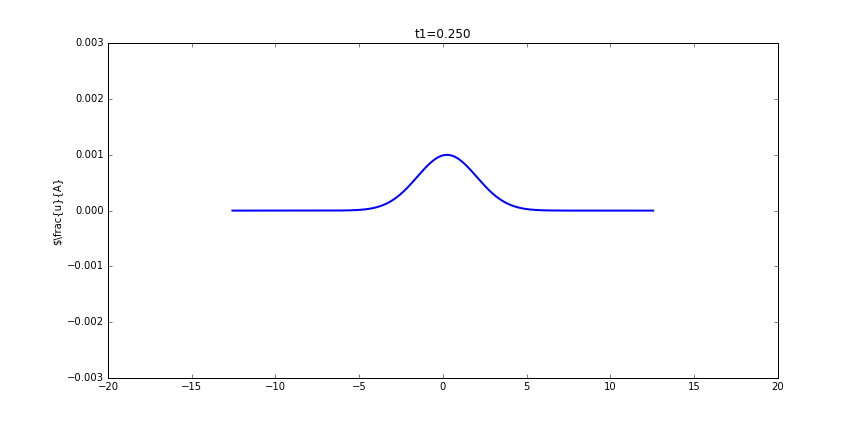
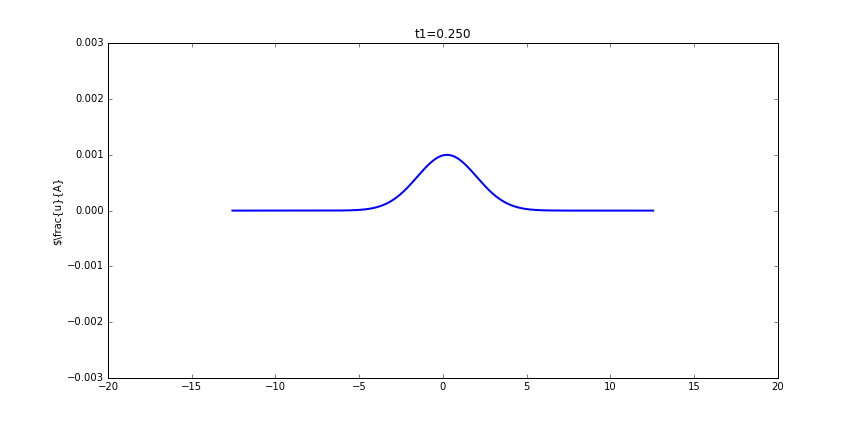
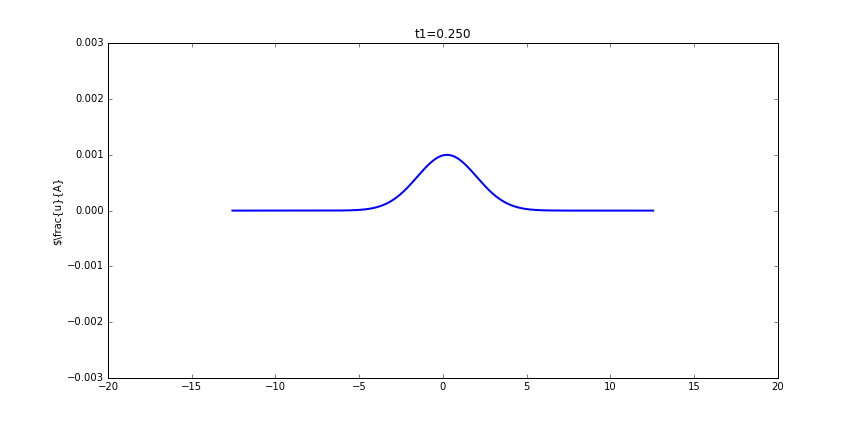
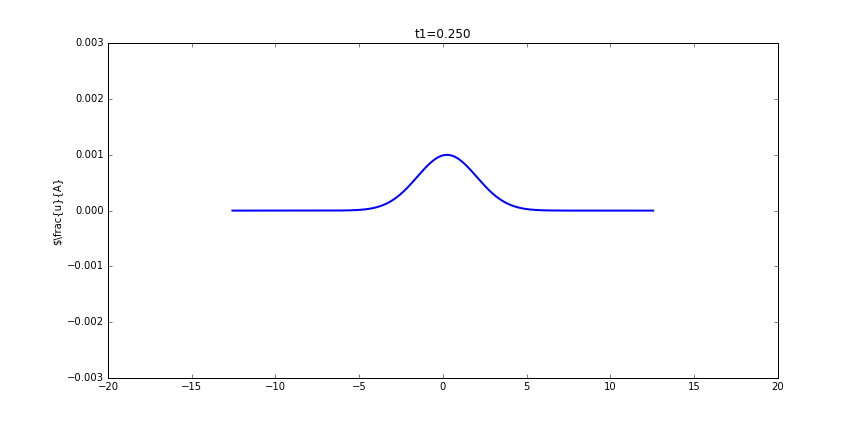
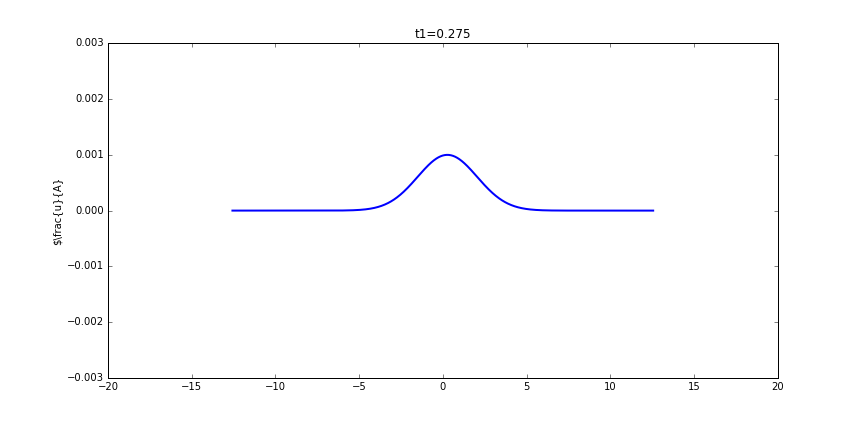
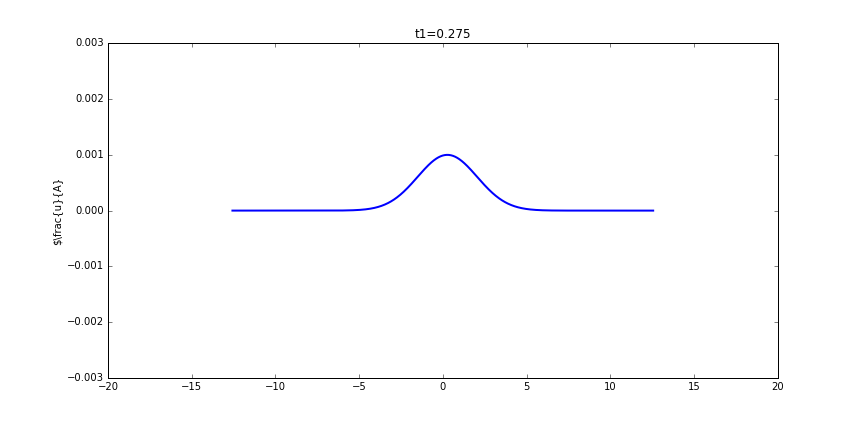
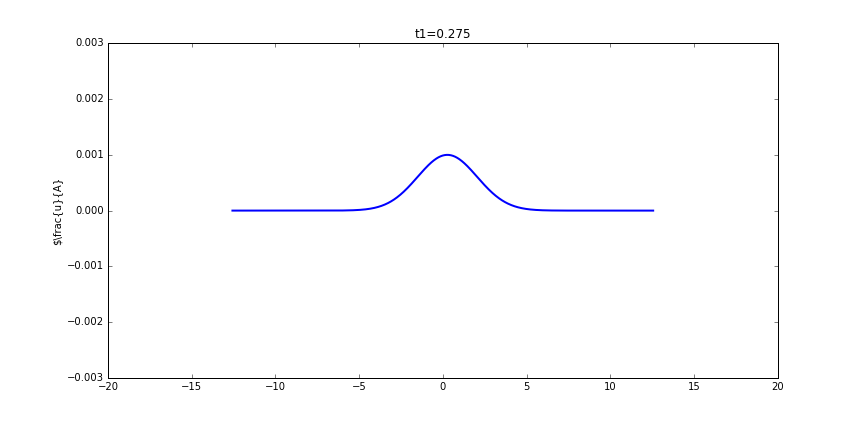
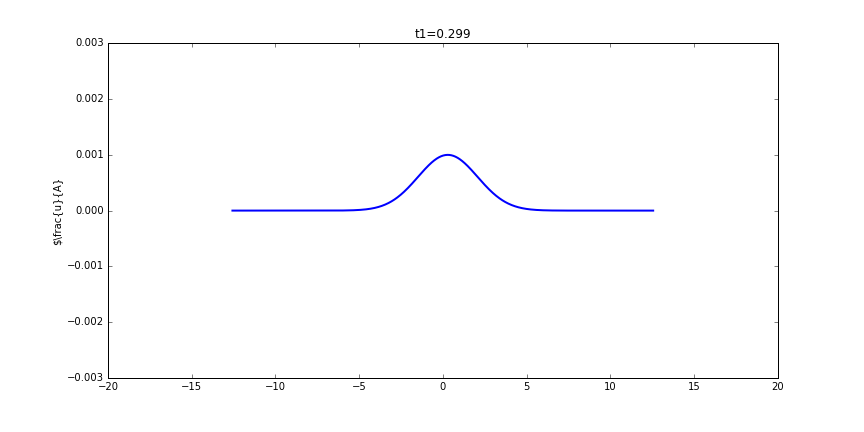
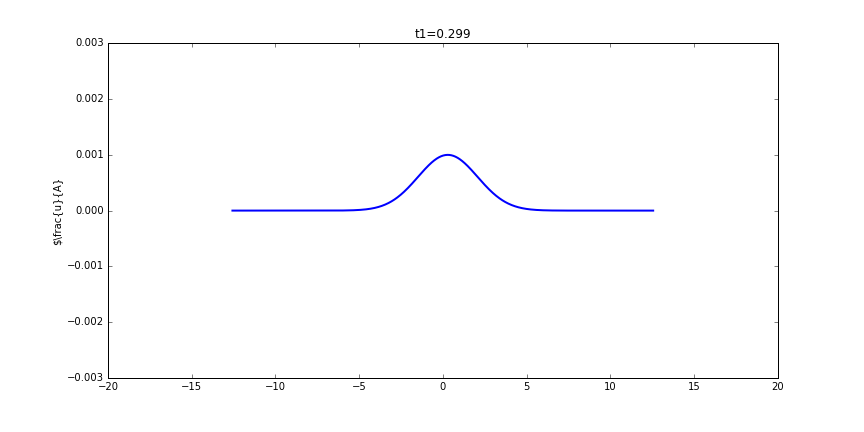
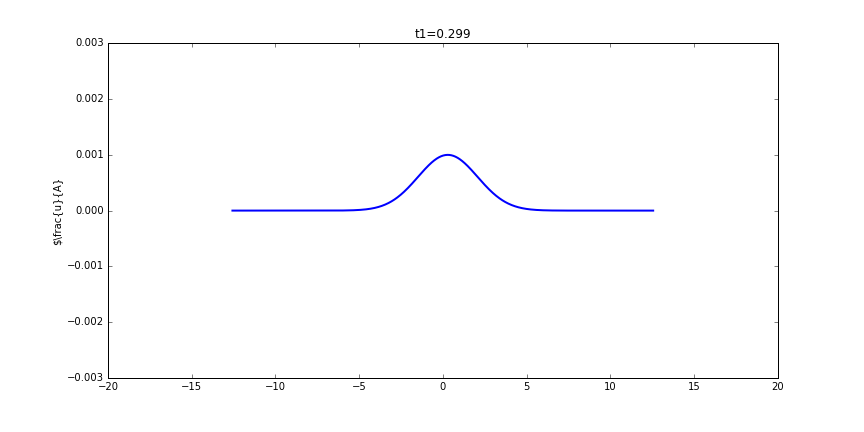
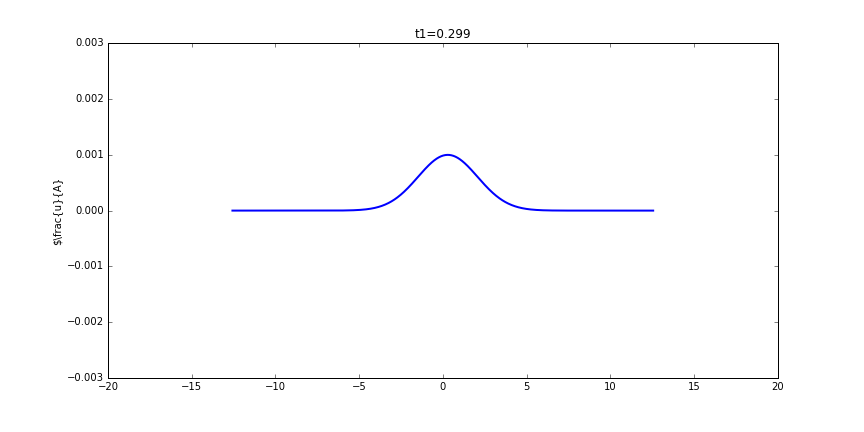
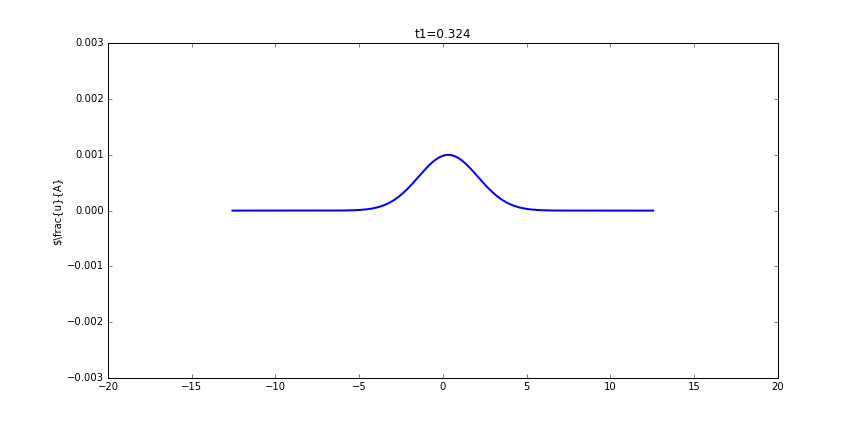
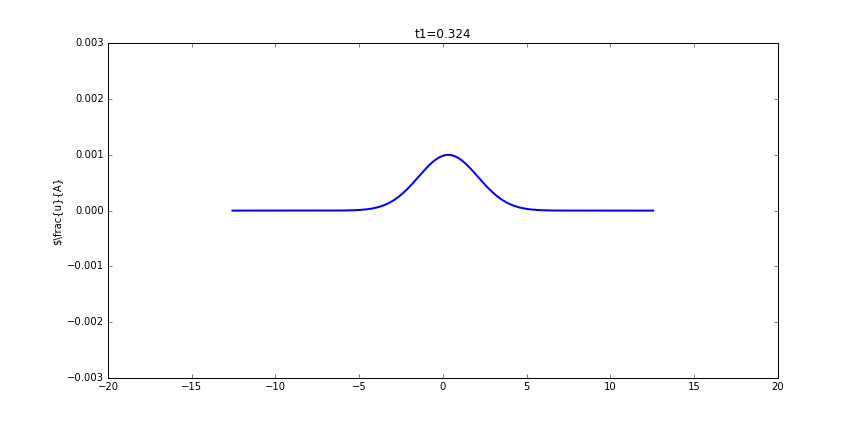
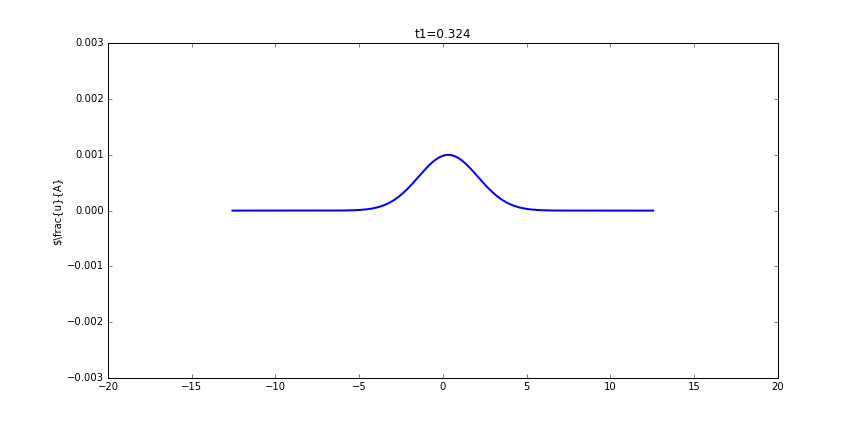
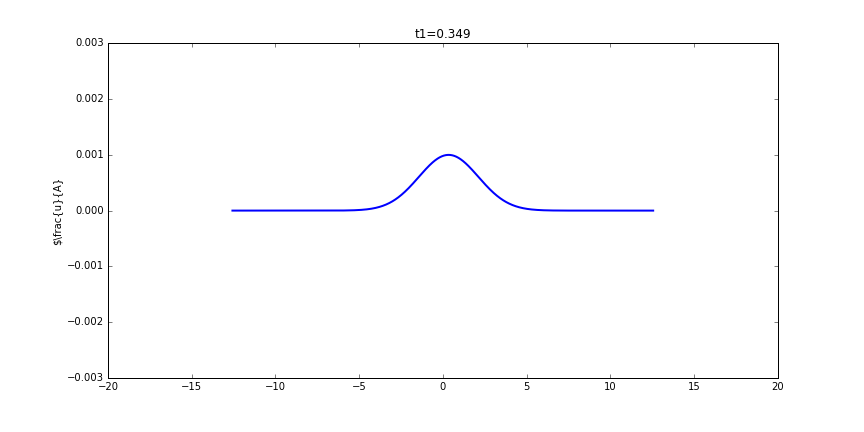
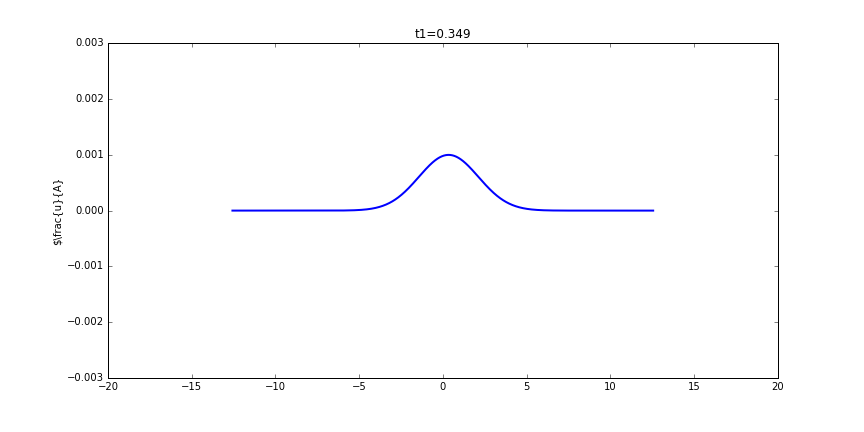
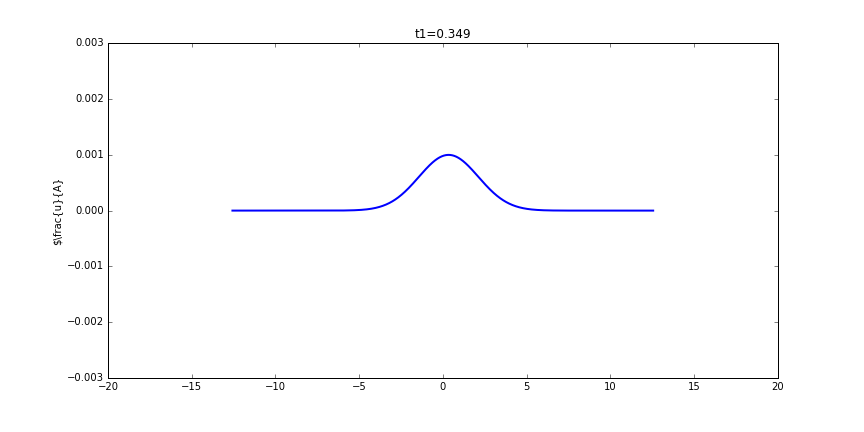
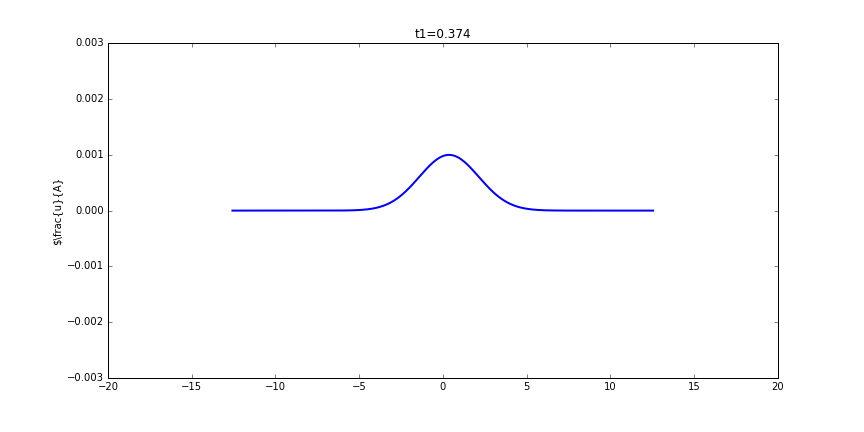
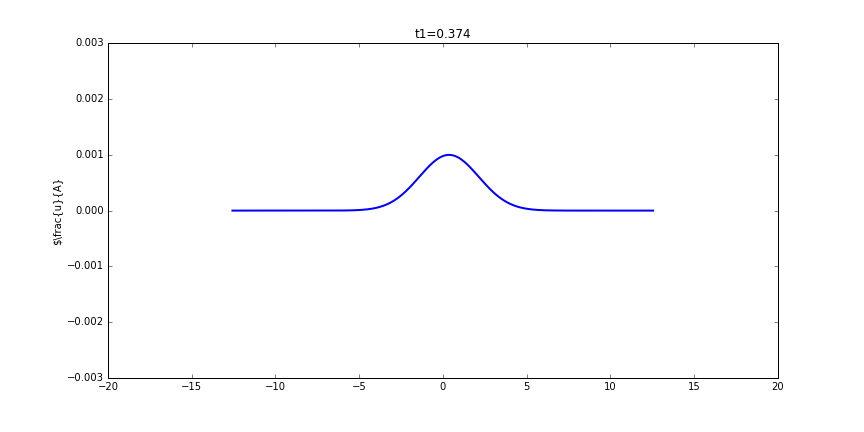
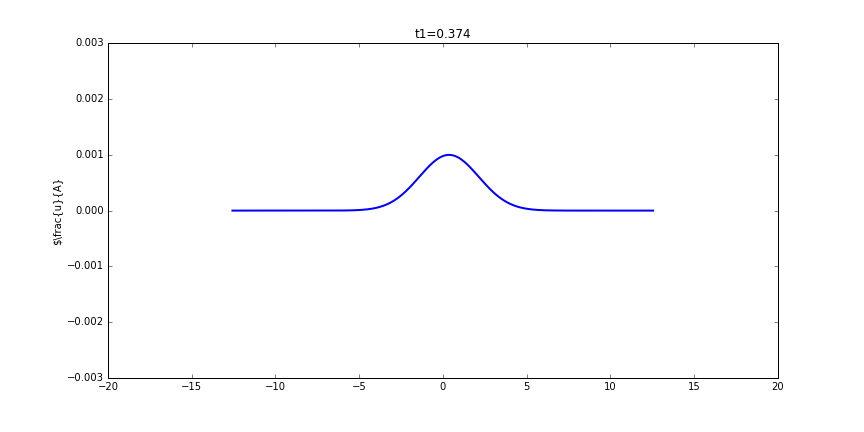
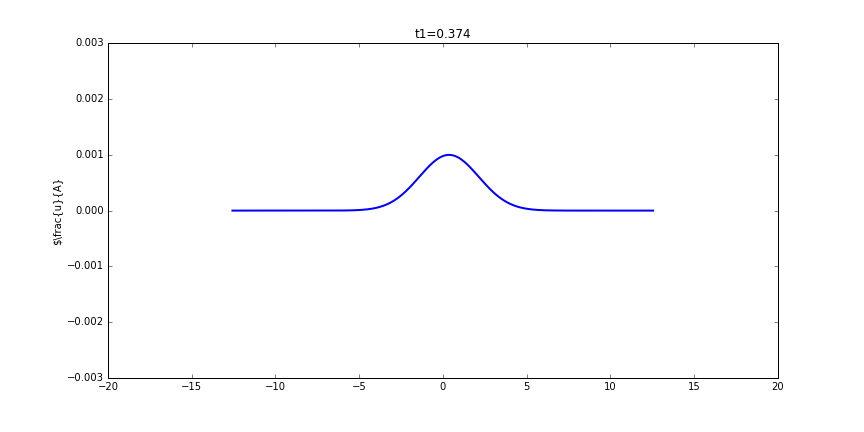
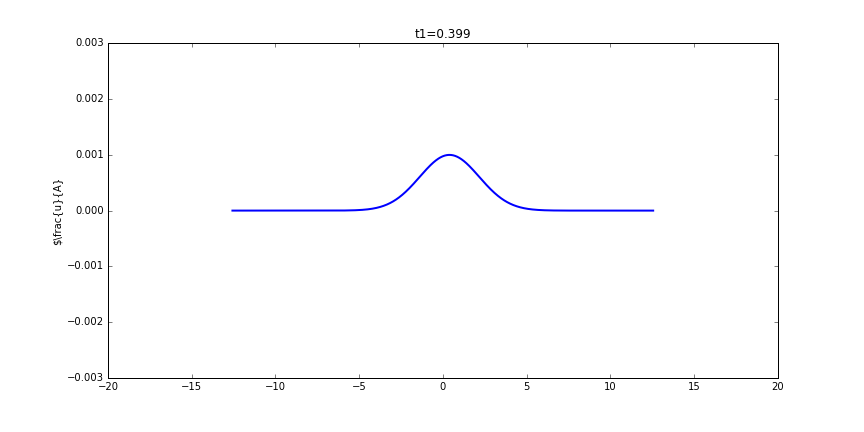
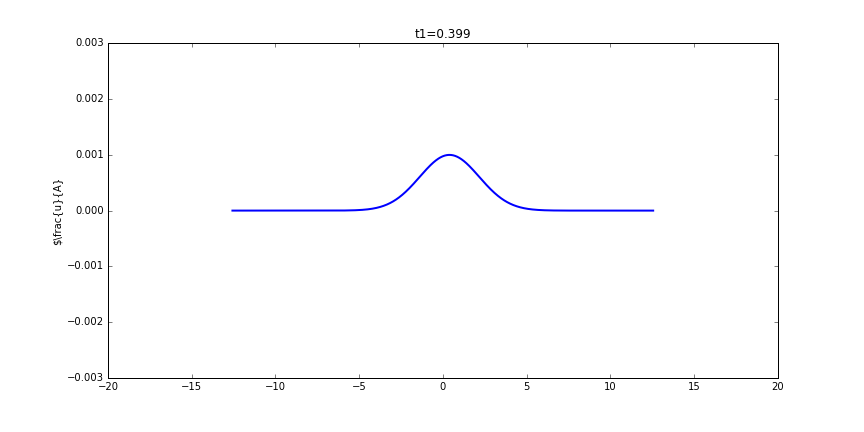
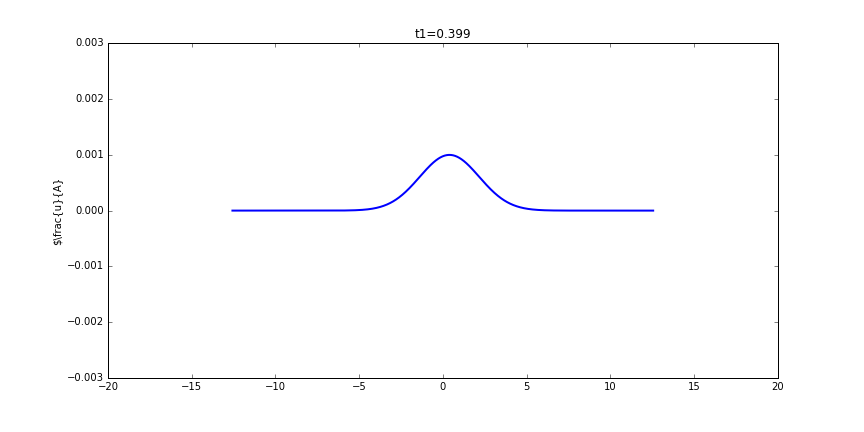
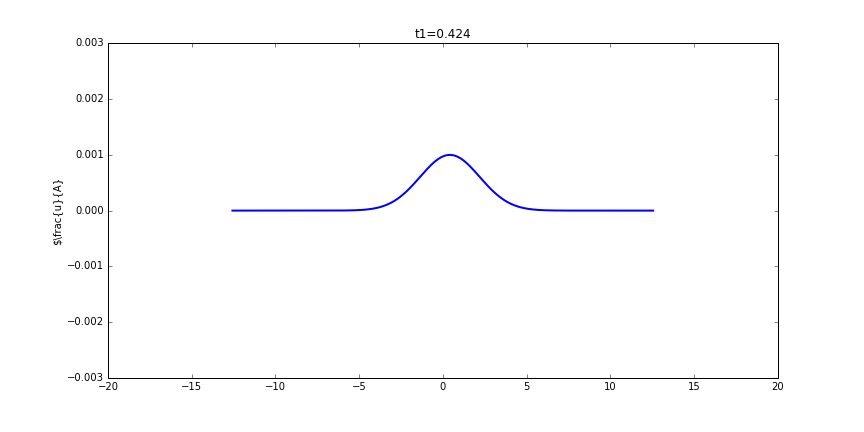
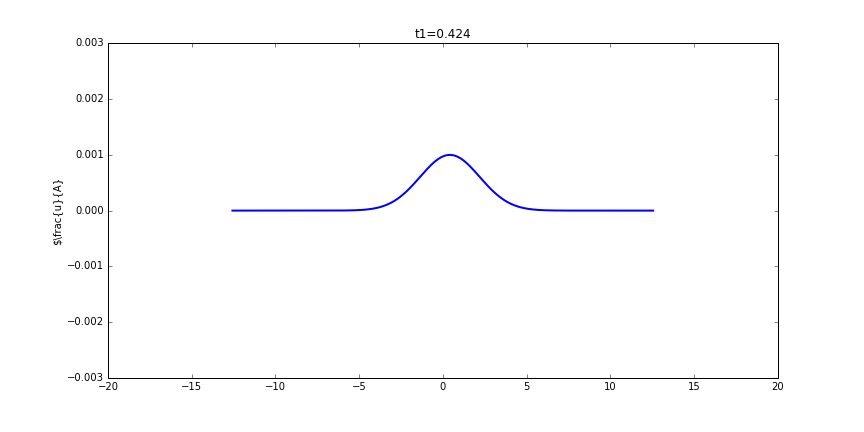
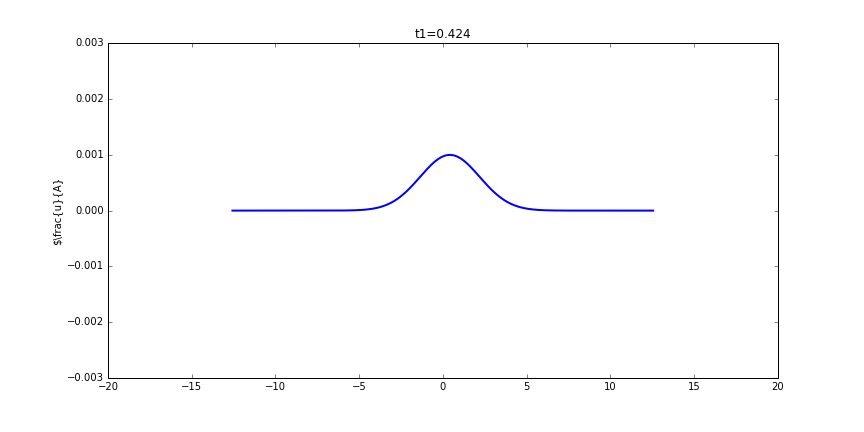
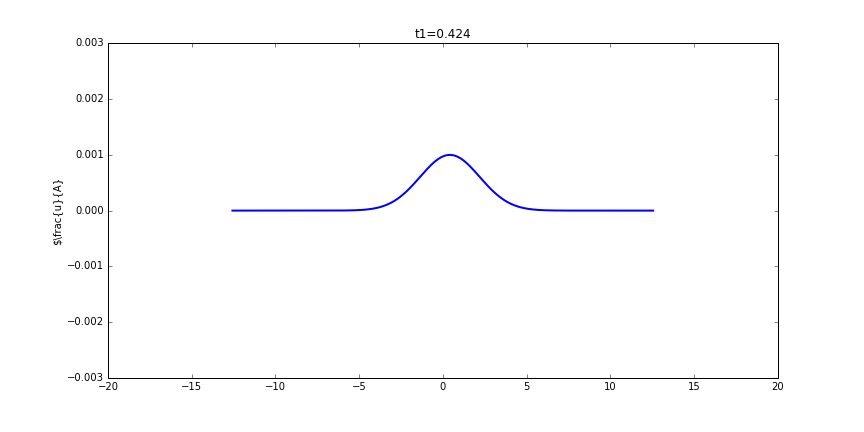
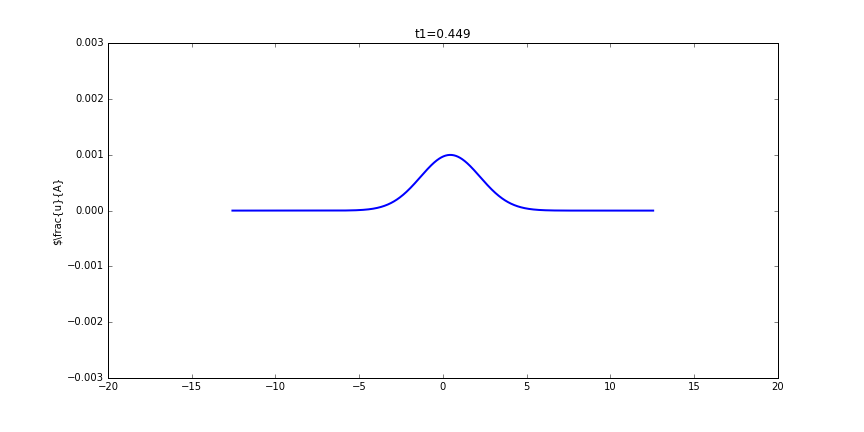
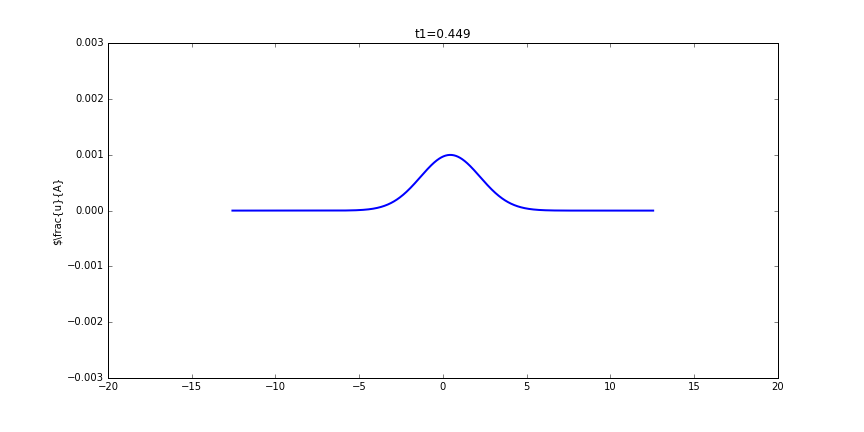
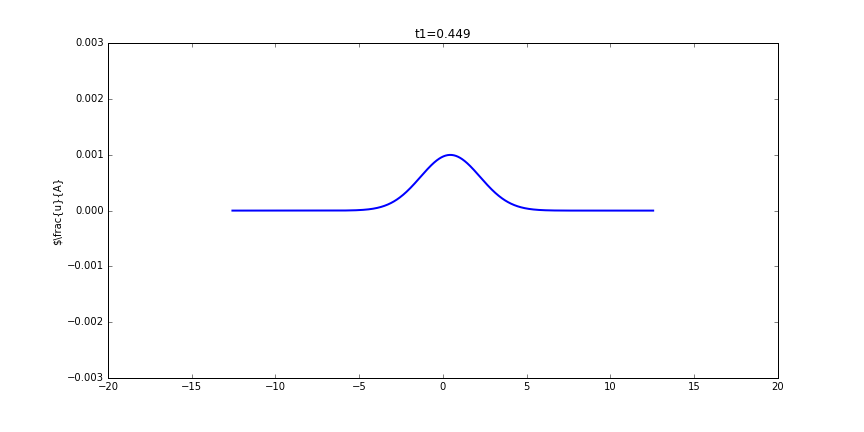
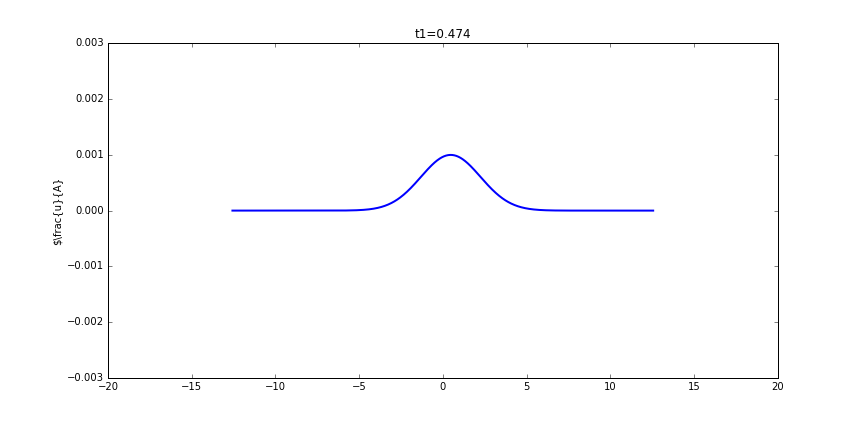
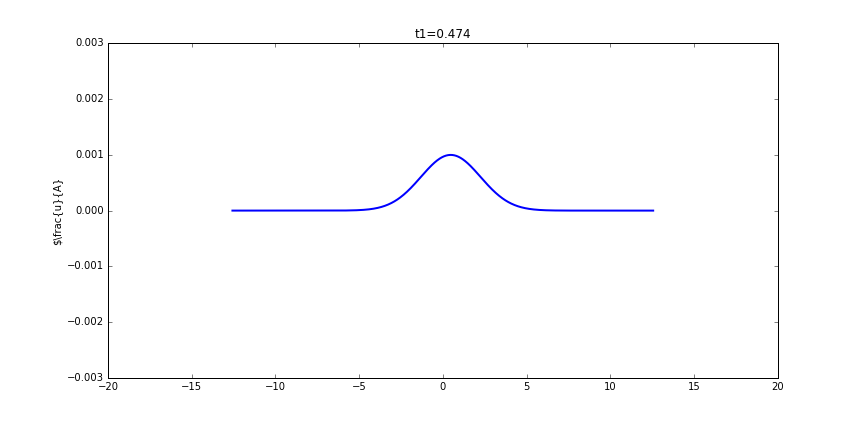
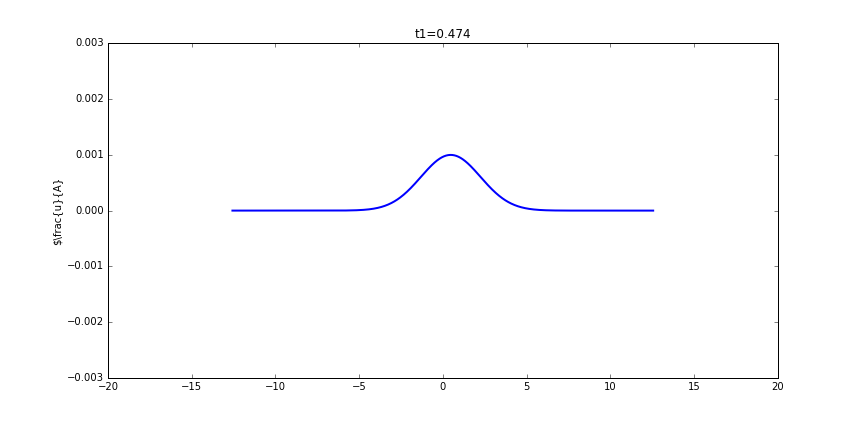
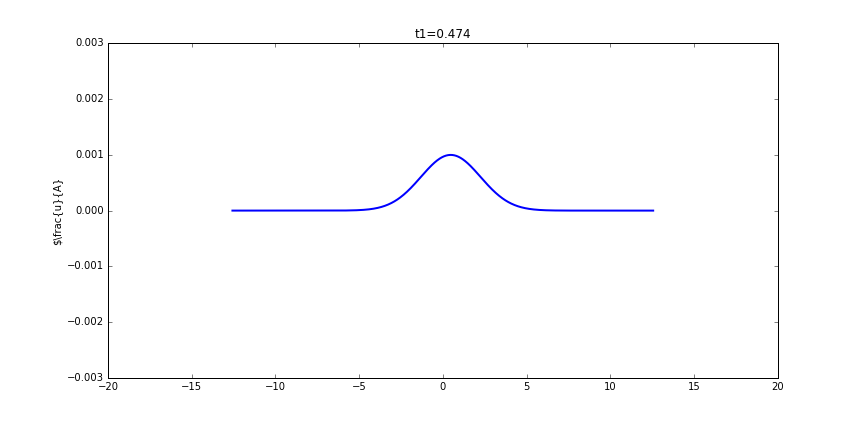

In [53]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure(figsize=(12,6))
ax = plt.axes(xlim=(-20, 20), ylim=(-3*A, 3*A))
line1, = ax.plot([], [], lw=2)
ax.set_ylabel(r'$\frac{u}{A}')
title = ax.set_title(r'$t=0.0 s$')

def animate(i):
    i1 = np.where(t1<=t3[i])[0][-1]
    line1.set_data(x, u1[:,i1]/1.0)
    title.set_text('t1=%.3f'%(t1[i1]))
    #ax.annotate(r'$t = %f $' %tall[i],(1,1))
    return line1

animation.FuncAnimation(fig, animate, frames=t3.shape[0]-1, interval=150)